# In this file we calibrate the Heston model through the pointwise random grids approach
In the forward pass we learn the **mapping** between **Heston parameters** and the option **implied volatility**, In this case the implied volatility surface is on an adaptive random grid 13(strikes)x11(maturities) a bit larger than the one used for the image based approach.

 In order to make a fair comparison we will consider the same parameters sets, then we will generate the random grids and create the dataset.
 
Below we upload the dataset .

In [1]:
#Set the directory of stored dataset
import os
os.chdir("C:/Users/pc/Desktop/politecnico/TESI/mio codice/Heston/grid based")

In [2]:
#import libraries
import gzip
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
#Open compressed dataset

f = gzip.GzipFile('HestonTrainSet.txt.gz', "r")
dat=np.load(f) #load data in a numpy array
xx=dat[:,:5]   #extract first 5 columns (Heston parameters)

print("\nInput (Heston parameter sets) shape (samples × 5 parameters):", xx.shape)
print("  - Each row contains: [ν₀, ρ, γ, θ, κ]")


Input (Heston parameter sets) shape (samples × 5 parameters): (12000, 5)
  - Each row contains: [ν₀, ρ, γ, θ, κ]


In [3]:
# ADD AN ADDITIONAL 4000 SETS OF PARAMETERS, USEFUL TO PRESERVE DATA QUALITY IN THE IMPLIED VOLATILITIES COMPUTATION
# ==================================================================================================================

# Check the existing data types
print("Data type of existing parameters:", xx.dtype)

# Define parameter bounds 
param_bounds = {
    'v0': (0.0001, 0.04),
    'rho': (-0.95, -0.1),
    'gamma': (0.01, 1.0),  # vol-vol
    'theta': (0.01, 0.2),  # mean reverting level
    'kappa': (1.0, 10.0)    # Mean reversion speed
}

# Generate 4000 new parameter sets that satisfy Feller condition (2κθ > γ²)
n_new_samples = 4000
new_params = np.zeros((n_new_samples, 5), dtype=xx.dtype)  # Use same dtype as existing data
rejected_count = 0
generated_count = 0

while generated_count < n_new_samples:
    # Generate candidate parameters
    v0 = np.random.uniform(low=param_bounds['v0'][0], high=param_bounds['v0'][1])
    rho = np.random.uniform(low=param_bounds['rho'][0], high=param_bounds['rho'][1])
    gamma = np.random.uniform(low=param_bounds['gamma'][0], high=param_bounds['gamma'][1])
    theta = np.random.uniform(low=param_bounds['theta'][0], high=param_bounds['theta'][1])
    kappa = np.random.uniform(low=param_bounds['kappa'][0], high=param_bounds['kappa'][1])
    
    # Check Feller condition (2κθ > γ²)
    if 2 * kappa * theta > gamma**2:
        new_params[generated_count, :] = [v0, rho, gamma, theta, kappa]
        generated_count += 1
    else:
        rejected_count += 1

# Combine with existing parameters
combined_params = np.vstack((xx, new_params))

# Print statistics
print(f"\nGenerated {n_new_samples} valid parameter sets")
print(f"Rejected {rejected_count} parameter sets that violated Feller condition")
print(f"Acceptance rate: {n_new_samples/(n_new_samples+rejected_count):.1%}")

# Verify the results
print("\nOriginal samples:", xx.shape)
print("New samples:", new_params.shape)
print("Combined samples:", combined_params.shape)
print("\nFirst 5 rows of new parameters:")
print(new_params[:5])
print("\nLast 5 rows of combined parameters:")
print(combined_params[-5:])

Data type of existing parameters: float64

Generated 4000 valid parameter sets
Rejected 810 parameter sets that violated Feller condition
Acceptance rate: 83.2%

Original samples: (12000, 5)
New samples: (4000, 5)
Combined samples: (16000, 5)

First 5 rows of new parameters:
[[ 1.64790323e-02 -1.76942886e-01  9.19606935e-01  1.50511985e-01
   9.79301616e+00]
 [ 4.84863350e-03 -9.30773535e-01  5.55494902e-01  7.66128234e-02
   8.23665202e+00]
 [ 1.95752092e-02 -1.01461490e-01  3.25384523e-01  1.48324784e-01
   8.75706165e+00]
 [ 1.18646942e-02 -2.58242406e-01  6.74532727e-02  3.27376877e-02
   1.63834653e+00]
 [ 2.66411944e-03 -7.91169372e-01  5.03342561e-01  1.97930887e-01
   4.68675407e+00]]

Last 5 rows of combined parameters:
[[ 2.45273873e-02 -1.34664513e-01  9.54157582e-02  1.74277945e-01
   3.94063650e+00]
 [ 2.49658185e-02 -7.07272793e-01  3.14376731e-01  8.24943333e-02
   2.85972636e+00]
 [ 1.76728020e-03 -8.93029479e-01  6.50856650e-02  7.74687132e-02
   1.91921720e+00]
 [ 3.4

# Let's have a look at the parameters sets and gain some more informations


=== HESTON PARAMETERS ANALYSIS (xx) ===
       ν₀ (initial variance)  ρ (spot-vol correlation)  γ (vol of variance)  \
count             16000.0000                16000.0000           16000.0000   
mean                  0.0181                   -0.3916               0.6066   
std                   0.0121                    0.2305               0.3308   
min                   0.0001                   -0.9498               0.0100   
1%                    0.0002                   -0.9284               0.0169   
5%                    0.0008                   -0.8539               0.0448   
50%                   0.0174                   -0.3172               0.7340   
95%                   0.0377                   -0.1197               0.9808   
99%                   0.0396                   -0.1039               0.9964   
max                   0.0400                   -0.1000               1.0000   

       θ (mean reverting level of variance)  κ (speed of mean reversion)  
count         

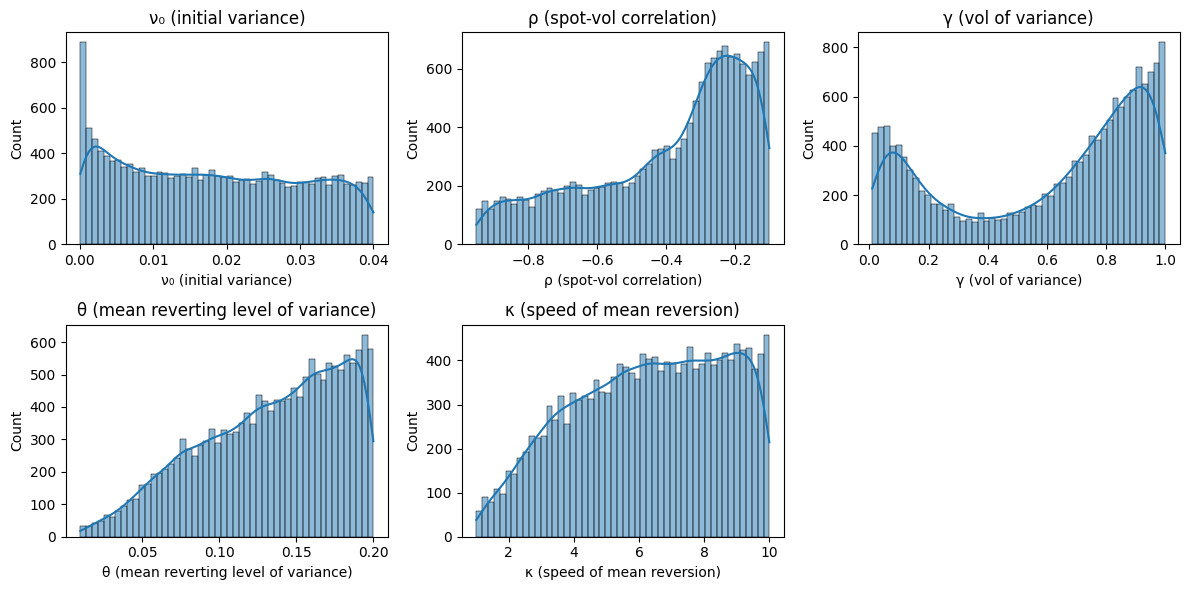

In [4]:
import seaborn as sns

#INPUT (HESTON PARAMETERS) ANALYSIS 

# Heston parameter names (for clarity)
#v0    ∈ [0.0001, 0.04]        (initial variance)
#rho   ∈ [-0.95, -0.1]         (spot-vol correlation)
#gamma ∈ [0.01, 1.0]           (vol of variance)
#theta ∈ [0.01, 0.2]           (mean reverting level of variance)
#kappa ∈ [1, 10.0]             (speed of mean reversion)
param_names = [
    'ν₀ (initial variance)',
    'ρ (spot-vol correlation)',
    'γ (vol of variance)',
    'θ (mean reverting level of variance)',
    'κ (speed of mean reversion)',
]


# Create DataFrame for statistical analysis
df_xx = pd.DataFrame(combined_params, columns=param_names)

# Descriptive statistics
print("\n=== HESTON PARAMETERS ANALYSIS (xx) ===")
print(df_xx.describe(percentiles=[0.01, 0.05, 0.95, 0.99]).round(4))

# Validate physical bounds
print("\n=== PHYSICAL BOUNDS ===")
print(f"ν₀:    Min={df_xx.iloc[:,0].min():.4f}, Max={df_xx.iloc[:,0].max():.4f} (Expected: ~[0.0001, 0.04])")
print(f"ρ:   Min={df_xx.iloc[:,1].min():.4f}, Max={df_xx.iloc[:,1].max():.4f} (Expected: ~[-0.95, -0.1])")
print(f"κ: Min={df_xx.iloc[:,4].min():.4f}, Max={df_xx.iloc[:,4].max():.4f} (Expected: ~[1, 10])")

# Plot distributions
plt.figure(figsize=(12, 6))
for i, col in enumerate(df_xx.columns):
    plt.subplot(2, 3, i+1)
    sns.histplot(df_xx[col], bins=50, kde=True)
    plt.title(col)
plt.tight_layout()
plt.show()

# Step 1: Data Generation


## **Inputs:** 
###  1. $\nu_{0}$ inital variance
###  2. $\rho$ spot-vol correlation
###  3. $\gamma$ vol of variance
###  4. $\theta$ mean reverting level of variance
###  5. $\kappa$ speed of mean reversion 
###  6. $K$ option strike price
###  7. $T$ option maturity
    
## **Output:**
### Option Implied volatility 

# Generate the random grids
We will associate each parameter set $\theta -> (K_i,T_j)_{i=1,..13}^{j=1,..,11}$ a unique random grid of couples of 11 maturities, each one uniformly sampled from a specified interval, for each maturity we will generate 13 strikes which will depend on the maturity (the longer, the more distanced the strikes)

In [ ]:
np.random.seed(42) # Fix seed for reproducibility

def generate_random_heston_grids(combined_params, S0=1.0, l=0.55, u=0.3):
    """
    Generates random grids for Heston parameters following specified rules.
    
    Args:
        combined_params: numpy array of Heston parameters (16000, 5) [ν₀, ρ, γ, θ, κ]
        S0: initial price (default 1.0)
        l: lower bound multiplier (default 0.55)
        u: upper bound multiplier (default 0.3)
        
    Returns:
        numpy array of shape (12000*143, 7) with columns: [ν₀, ρ, γ, θ, κ, strike, maturity]
    """
    # Define maturity intervals (11 intervals)
    maturity_intervals = [
        (0.003, 0.03), (0.03, 0.09), (0.09, 0.15), (0.15, 0.3), (0.3, 0.5),
        (0.5, 0.75), (0.75, 1.0), (1.0, 1.25), (1.25, 1.5), (1.5, 2.0), (2.0, 2.5)
    ]
    
    num_samples = combined_params.shape[0]
    num_points_per_sample = 11 * 13  # 11 maturities × 13 strikes each
    total_points = num_samples * num_points_per_sample
    
    # Initialize output array
    output = np.zeros((total_points, 7))
    
    for i in range(num_samples):
        # Get current Heston parameters
        heston_params = combined_params[i]
        
        # Generate points for this parameter set
        points = np.zeros((num_points_per_sample, 7))
        
        for j, (t_min, t_max) in enumerate(maturity_intervals):
            # Generate random maturity in this interval
            T = np.random.uniform(t_min, t_max)
            
            # Calculate strike bounds
            sqrt_T = np.sqrt(T)
            K_min = S0 * (1 - l * sqrt_T)
            K_max = S0 * (1 + u * sqrt_T)
            K_mid_low = S0 * (1 - 0.2 * sqrt_T)
            K_mid_high = S0 * (1 + 0.2 * sqrt_T)
            
            # Generate strikes according to specified distribution
            # 4 strikes in [K_min, K_mid_low]
            strikes_low = np.random.uniform(K_min, K_mid_low, 4)
            strikes_low = np.sort(strikes_low)   #sort the strikes
            
            # 7 strikes in [K_mid_low, K_mid_high]
            strikes_mid = np.random.uniform(K_mid_low, K_mid_high, 7)
            strikes_mid = np.sort(strikes_mid)   #sort the strikes

            # 2 strikes in [K_mid_high, K_max]
            strikes_high = np.random.uniform(K_mid_high, K_max, 2)
            strikes_high = np.sort(strikes_high)   #sort the strikes
            # Combine all strikes
            strikes = np.concatenate([strikes_low, strikes_mid, strikes_high])
            
            # Create points for this maturity
            start_idx = j * 13
            end_idx = (j + 1) * 13
            
            # Fill Heston parameters
            points[start_idx:end_idx, :5] = heston_params
            
            # Fill strikes
            points[start_idx:end_idx, 5] = strikes
            
            # Fill maturity
            points[start_idx:end_idx, 6] = T
        
        # Add to output array
        output[i*num_points_per_sample:(i+1)*num_points_per_sample] = points
    
    return output

random_grid_data = generate_random_heston_grids(combined_params)
print(f"Random grid dataset shape: {random_grid_data.shape}") # Output shape will be (16000*143, 7) = (2,288,000, 7)

# Print the first two rows as example
print("First two rows of the generated dataset:")
print("Columns: [ν₀, ρ, γ, θ, κ, strike, maturity]")
for i in range(2):
    print(f"Row {i+1}: {random_grid_data[i]}")

Random grid dataset shape: (2288000, 7)
First two rows of the generated dataset:
Columns: [ν₀, ρ, γ, θ, κ, strike, maturity]
Row 1: [ 0.01683994 -0.12410636  0.87622854  0.16472127  9.58028822  0.9432724
  0.01311258]
Row 2: [ 0.01683994 -0.12410636  0.87622854  0.16472127  9.58028822  0.96101277
  0.01311258]


Now we have to compute the EU vanilla call prices through FFT to have the ground truth of the forward pass, here's the **FFT algorithm** to compute them

In [7]:
from scipy.interpolate import interp1d
from scipy.optimize import brentq
from scipy.stats import norm

def char_exp(v, params,T):
    """
    Characteristic exponent for Heston 1993 model (B(ψ) + C(ψ))
    
    Parameters:
    - v: Fourier transform variable (can be array or scalar)
    - params: tensor containing Heston parameters:
    -T: time to maturity
    
    Returns:
    - Characteristic exponent value(s)
    """
    # Extract parameters [ν₀, ρ, γ, θ, κ]
    V0 = params[0]
    rho = params[1]
    gamma = params[2]
    theta = params[3]
    kappa = params[4]
     
    # Calculate intermediate terms
    zeta = -0.5 * (v**2 + 1j*v)  # ζ(ω)
    gamma_adj = kappa - rho * gamma * v * 1j  # γ(ω)
    psi = np.sqrt(gamma_adj**2 - 2 * gamma**2 * zeta)  # ψ(ω)
    
    # Calculate B(ψ)
    numerator_B = 2 * zeta * (1 - np.exp(-psi * T)) * V0
    denominator_B = 2 * psi - (psi - gamma_adj) * (1 - np.exp(-psi * T))
    B = numerator_B / denominator_B
    
    # Calculate C(ψ)
    log_term = np.log((2 * psi - (psi - gamma_adj) * (1 - np.exp(-psi * T))) / (2 * psi))
    C = (-2 * kappa * theta / gamma**2) * (2 * log_term + (psi - gamma_adj) * T)
    
    return B + C

def cf_Heston(v, T, r, params):
    """
    Heston characteristic function as proposed by Schoutens (2004)
    
    Parameters:
    - v: Fourier transform variable (can be array or scalar)
    - T: time to maturity
    - r: risk-free interest rate
    - params: tensor containing Heston parameters:

    
    Returns:
    - Characteristic function value(s)
    """
    # Extract parameters [ν₀, ρ, γ, θ, κ]
    v0 = params[0]
    rho = params[1]
    gamma = params[2]
    theta = params[3]
    kappa = params[4]

    xi = kappa - gamma * rho * v * 1j
    d = np.sqrt(xi**2 + gamma**2 * (v**2 + 1j * v))
    g1 = (xi + d) / (xi - d)
    g2 = 1 / g1
    cf = np.exp(
        1j * v * r * T
        + (kappa * theta) / (gamma**2) * ((xi - d) * T - 2 * np.log((1 - g2 * np.exp(-d * T)) / (1 - g2)))
        + (v0 / gamma**2) * (xi - d) * (1 - np.exp(-d * T)) / (1 - g2 * np.exp(-d * T))
    )
    return cf


def FFT_CM_Call(Strike, params, T, r, S0):
    """
    Compute EU vanilla option prices using Carr-Madan FFT method
    
    Parameters:
    - Strike: Strike prices
    - params: Model parameters
    - T: Time to maturity
    - r: Risk-free rate
    - S0: Spot price
    
    Returns:
    - Option prices for that given maturity
    """
    # Discretization parameters
    Npow = 15
    N = 2**Npow
    A = 1200

    # Discretization step
    eta = A/N
    
    # Avoid division by zero
    v = np.arange(0, A*(N-1)/N + eta, eta)
    v[0] = 1e-22

    # Numerical parameter for log-moneyness grid
    lambda_param = 2 * np.pi / (N * eta)
    
    # Grid of log-moneyness
    k = -lambda_param * N/2 + lambda_param * np.arange(N)

    # Characteristic function
    #char_func = lambda v: np.exp(char_exp(v, params,T))
    char_func = lambda v: cf_Heston(v, T, r, params)

    # Carr-Madan argument of inverse Fourier transform
    Z_k = np.exp(1j * r * v * T) * \
          (char_func(v - 1j) - 1) / (1j * v * (1j * v + 1))

    # Trapezoidal integration weights
    w = np.ones(N)
    w[0] = 0.5
    w[-1] = 0.5

    # Compute option prices via FFT
    x = w * eta * Z_k * np.exp(1j * np.pi * np.arange(N))
    z_k = np.real(np.fft.fft(x) / np.pi)

    # Compute strikes and call prices
    K = S0 * np.exp(k)
    C = S0 * (z_k + np.maximum(1 - np.exp(k - r * T), 0))

    # Filter reasonable strikes
    index = np.where((K > 0.1 * S0) & (K < 3 * S0))[0]
    K_filtered = K[index]
    C_filtered = C[index]

    # Interpolate to get prices for given strikes
    price_interp = interp1d(K_filtered, C_filtered, kind='cubic', 
                             fill_value='extrapolate')
    
    prices = price_interp(Strike)
    return np.maximum(prices, 1e-8)  # Ensure no price is below 1e-8

# Define B&S price function 
def black_scholes_price(S, K, T, r, sigma, option_type='call'):
    """
    Calculate Black-Scholes option price
    
    Parameters:
    - S: Spot price
    - K: Strike price
    - T: Time to maturity
    - r: Risk-free rate
    - sigma: Volatility
    - option_type: 'call' or 'put'
    
    Returns:
    - Option price
    """
    d1 = (np.log(S/K) + (r + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    
    if option_type == 'call':
        price = S*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)
    else:
        price = K*np.exp(-r*T)*norm.cdf(-d2) - S*norm.cdf(-d1)
    
    return price

#Define function to compute IV using Brent's method
def implied_volatility(market_price, S, K, T, r, option_type='call'):
    """
    Calculate implied volatility using Brent's method
    
    Parameters:
    - market_price: Observed market price of option
    - S: Spot price
    - K: Strike price
    - T: Time to maturity
    - r: Risk-free rate
    - option_type: 'call' or 'put'
    
    Returns:
    - Implied volatility
    """
    # Define the price difference function to find root of
    def price_diff(sigma):
        return black_scholes_price(S, K, T, r, sigma, option_type) - market_price
    
    # Brent's method bounds (0.0001% to 100%)
    try:
        iv = brentq(price_diff, 1e-6, 1.0, maxiter=4000)
        return  np.clip(iv, 1e-6, 1.0)
    except ValueError:
        # Handle cases where solution is not found
        return np.nan

def FFT_CM_Call_IV(Strike, params, T, r, S0):
    """
    Compute EU vanilla option implied volatilities using Carr-Madan FFT method
    
    Parameters:
    - Strike: Strike prices
    - params: Model parameters
    - T: Time to maturity
    - r: Risk-free rate
    - S0: Spot price
    
    Returns:
    - Implied volatilities for given strikes
    """
    # Get option prices using FFT implementation
    call_prices = FFT_CM_Call(Strike, params, T, r, S0)
    
    # Calculate implied volatilities
    ivs = np.zeros_like(Strike)
    for i, (strike, price) in enumerate(zip(Strike, call_prices)):
        ivs[i] = implied_volatility(price, S0, strike, T, r)
    
    return ivs

# Example usage:
ex_params = random_grid_data[0,:5]  # Sample Heston parameters
ex_T = random_grid_data[0,6]  # Maturity
r = 0.0  # Risk-free rate
S0 = 1.0  # Spot price
ex_strikes = random_grid_data[:3,5]  # Sample strikes

ivs = FFT_CM_Call_IV(ex_strikes, ex_params, ex_T, r, S0)
print("Implied Volatilities:", ivs)

Implied Volatilities: [0.17931711 0.17119805 0.16888202]


Now we compute the implied volatilities for all the options, thanks to the FFT we're able to process all the 13 strikes for a given maturity, making this procedure 13 times faster with respect to truly pointwise approaches

In [10]:
from tqdm import tqdm  # For progress bar

def calculate_all_implied_vols(random_grid_data, S0=1.0, r=0.0):
    """
    Calculate implied volatilities for all option points in the random grid dataset.
    
    Args:
        random_grid_data: numpy array of shape (N*143, 7) with columns:
                         [ν₀, ρ, γ, θ, κ, strike, maturity]
        S0: initial spot price (default 1.0)
        r: risk-free rate (default 0.0)
        
    Returns:
        Tuple of (implied_vols_array, valid_indices) where:
        - implied_vols_array: array of shape (N*143,) with IVs (NaN where calculation failed)
        - valid_indices: indices of points where IV calculation succeeded
    """
    num_samples = len(random_grid_data) // 143
    implied_vols = np.full(len(random_grid_data), np.nan)
    
    # Process each parameter set (each 143 options)
    for i in tqdm(range(num_samples), desc="Processing parameter sets"):
        # Get current parameter set and all its options
        start_idx = i * 143
        end_idx = (i + 1) * 143
        current_batch = random_grid_data[start_idx:end_idx]
        
        # Extract parameters (same for all 143 options)
        params = current_batch[0, :5]
        
        # Group options by maturity for efficient FFT pricing
        unique_maturities = np.unique(current_batch[:, 6])
        
        for T in unique_maturities:
            # Get all strikes for this maturity
            maturity_mask = current_batch[:, 6] == T
            strikes = current_batch[maturity_mask, 5]
            
            # Price all options for this maturity with single FFT call
            try:
                ivs = FFT_CM_Call_IV(strikes, params, T, r, S0)
                
                # Store results at the correct positions
                implied_vols[start_idx:end_idx][maturity_mask] = ivs
            except Exception as e:
                print(f"\nError processing parameter set {i+1}, maturity {T:.4f}: {str(e)}")
                continue
    
    # Identify valid results (non-NaN)
    valid_indices = np.where(~np.isnan(implied_vols))[0]
    
    print(f"\nCalculation completed. Success rate: {len(valid_indices)/len(implied_vols):.2%}")
    return implied_vols, valid_indices

implied_vols, valid_idx = calculate_all_implied_vols(random_grid_data)

Processing parameter sets: 100%|██████████| 16000/16000 [2:21:05<00:00,  1.89it/s] 


Calculation completed. Success rate: 99.75%


In [11]:
# QUICK ANALYISIS OF IMPLIED VOLATILITIES COMPUTATION
failed_mask = np.isnan(implied_vols)
num_failed = failed_mask.sum()

if num_failed > 0:
    failed_points = random_grid_data[failed_mask]
    
    # Get unique parameter sets with at least one failure
    failed_params = np.unique(failed_points[:, :5], axis=0)
    num_failed_paramsets = len(failed_params)
    
    print(f"\nDiagnostic Summary:")
    print(f"Total failed calculations: {num_failed}")
    print(f"Unique parameter sets with failures: {num_failed_paramsets}")
else:
    print("\nAll calculations succeeded!")


Diagnostic Summary:
Total failed calculations: 5655
Unique parameter sets with failures: 2359


In [12]:
# NEED TO HANDLE FAILURES IN IMPLIED VOLATILITY COMPUTATION, ENSURE DATA QUALITY
# Cut out parameters sets with failures.

def keep_only_perfect_blocks(random_grid_data, implied_vols, points_per_sample=143):
    """
    Strict cleaning that only keeps parameter sets with ALL 143 implied volatilities valid.
    
    Args:
        random_grid_data: (N*143, 7) array of [params, strike, maturity]
        implied_vols: (N*143,) array of implied volatilities
        points_per_sample: Points per parameter set (default 143)
        
    Returns:
        clean_data: (M*143, 7) array with complete blocks only
        clean_ivs: (M*143,) array without any NaNs
        n_dropped: Number of full parameter sets dropped
    """
    n_samples = len(random_grid_data) // points_per_sample
    clean_data = []
    clean_ivs = []
    n_dropped = 0
    
    for i in range(n_samples):
        block_start = i * points_per_sample
        block_end = (i+1) * points_per_sample
        block_ivs = implied_vols[block_start:block_end]
        
        # Keep only if ALL IVs are valid
        if not np.isnan(block_ivs).any():
            clean_data.append(random_grid_data[block_start:block_end])
            clean_ivs.append(block_ivs)
        else:
            n_dropped += 1
    
    # Combine results if we found valid blocks
    if clean_data:
        final_data = np.vstack(clean_data)
        final_ivs = np.concatenate(clean_ivs)
    else:
        final_data = np.empty((0, 7))
        final_ivs = np.empty((0,))
    
    print(f"\nStrict cleaning results:")
    print(f"Complete blocks kept: {len(clean_data)}/{n_samples}")
    print(f"Blocks dropped: {n_dropped}")
    print(f"Final dataset size: {len(final_ivs)} options ({final_data.shape[0]//points_per_sample} parameter sets)")
    
    return final_data, final_ivs, n_dropped

# Usage example:
clean_data, clean_ivs, n_dropped = keep_only_perfect_blocks(random_grid_data, implied_vols)


Strict cleaning results:
Complete blocks kept: 13641/16000
Blocks dropped: 2359
Final dataset size: 1950663 options (13641 parameter sets)


=== Dataset Integrity Checks ===
NaN in clean_data: False
NaN in clean_ivs: False
IV range: [0.0178, 0.5770]

=== Parameter Set Validation ===
Found 13641 unique parameter sets

=== Option Structure Validation ===
Maturities per set: 11 (expected: 11)
Options per maturity: 13 (expected: 13)

=== First Parameter Set Sample ===
Parameters: [ 0.01683994 -0.12410636  0.87622854  0.16472127  9.58028822]
First 5 options:
K=0.9433 | T=0.0131 | IV=0.1793
K=0.9610 | T=0.0131 | IV=0.1712
K=0.9664 | T=0.0131 | IV=0.1689
K=0.9751 | T=0.0131 | IV=0.1653
K=0.9780 | T=0.0131 | IV=0.1642
IV Statistics:
- Total points: 1950663
- Valid IV [0-1]: 1950663 (100.00%)
- Negative IV: 0 (0.00%)
- IV > 1: 0 (0.00%)


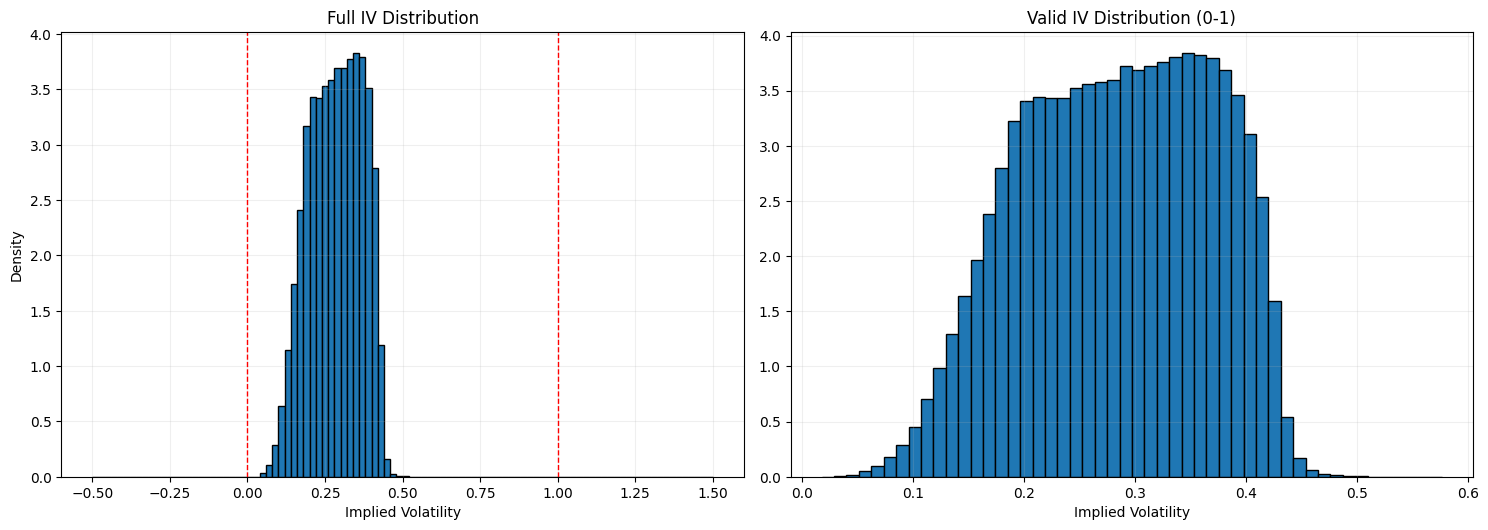

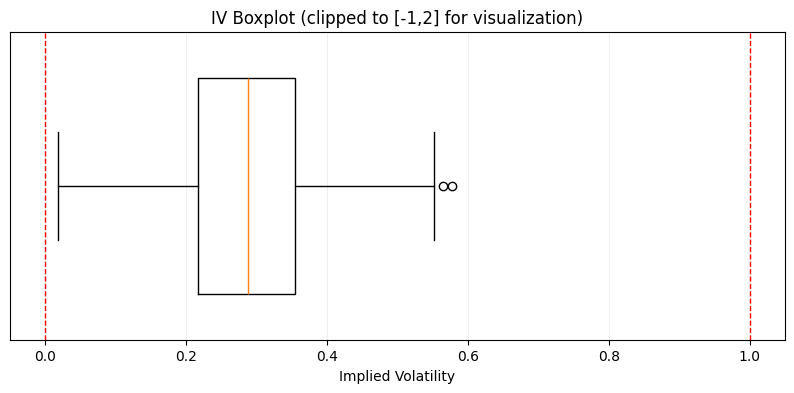

In [13]:
# HAVE MORE INSIGHTS ON THE DATA AND THE DISTRIBUTION OF IMPLIED VOLATILITIES
#================================================================================

def verify_clean_dataset(clean_data, clean_ivs, points_per_sample=143):
    """
    Performs comprehensive validation on cleaned dataset:
    1. Checks for remaining NaN values
    2. Validates implied volatility range (0-1)
    3. Verifies parameter set ordering consistency
    4. Checks maturity/strike structure
    
    Args:
        clean_data: (N*143, 7) array of [params, strike, maturity]
        clean_ivs: (N*143,) array of implied volatilities
        points_per_sample: Points per parameter set (default 143)
    """
    # --- Basic Integrity Checks ---
    print("=== Dataset Integrity Checks ===")
    print(f"NaN in clean_data: {np.isnan(clean_data).any()}")
    print(f"NaN in clean_ivs: {np.isnan(clean_ivs).any()}")
    print(f"IV range: [{clean_ivs.min():.4f}, {clean_ivs.max():.4f}]")
    
    # --- Parameter Set Consistency ---
    print("\n=== Parameter Set Validation ===")
    sample_params = clean_data[::points_per_sample, :5]  # Get first row of each block
    unique_params = np.unique(sample_params, axis=0)
    print(f"Found {len(unique_params)} unique parameter sets")
    
    # --- Strike/Maturity Structure Verification ---
    print("\n=== Option Structure Validation ===")
    first_block = clean_data[:points_per_sample]
    maturities, counts = np.unique(first_block[:,6], return_counts=True)
    print(f"Maturities per set: {len(maturities)} (expected: 11)")
    print(f"Options per maturity: {counts[0]} (expected: 13)")
    
    # --- Sample Data Inspection ---
    print("\n=== First Parameter Set Sample ===")
    print("Parameters:", clean_data[0,:5])
    print("First 5 options:")
    for i in range(5):
        print(f"K={clean_data[i,5]:.4f} | T={clean_data[i,6]:.4f} | IV={clean_ivs[i]:.4f}")

def analyze_iv_distribution(clean_ivs):
    """
    Comprehensive analysis of implied volatility distribution:
    - Statistical summary
    - Visualization of valid/invalid ranges
    - Outlier detection
    
    Args:
        clean_ivs: Array of implied volatilities
    """
    # --- Statistical Analysis ---
    stats = {
        'total': len(clean_ivs),
        'valid': np.sum((clean_ivs >= 0) & (clean_ivs <= 1)),
        'negative': np.sum(clean_ivs < 0),
        'excessive': np.sum(clean_ivs > 1)
    }
    
    print(f"IV Statistics:\n"
          f"- Total points: {stats['total']}\n"
          f"- Valid IV [0-1]: {stats['valid']} ({stats['valid']/stats['total']:.2%})\n"
          f"- Negative IV: {stats['negative']} ({stats['negative']/stats['total']:.2%})\n"
          f"- IV > 1: {stats['excessive']} ({stats['excessive']/stats['total']:.2%})")

    # --- Visualization ---
    plt.figure(figsize=(15,10))
    
    # Main distribution plot
    plt.subplot(2,2,1)
    plt.hist(clean_ivs, bins=100, range=(-0.5,1.5), density=True, edgecolor='k')
    plt.axvline(0, c='r', ls='--', lw=1)
    plt.axvline(1, c='r', ls='--', lw=1)
    plt.title('Full IV Distribution')
    plt.xlabel('Implied Volatility')
    plt.ylabel('Density')
    plt.grid(alpha=0.2)

    # Valid range zoom
    plt.subplot(2,2,2)
    valid_ivs = clean_ivs[(clean_ivs >=0) & (clean_ivs <=1)]
    plt.hist(valid_ivs, bins=50, density=True, edgecolor='k')
    plt.title('Valid IV Distribution (0-1)')
    plt.xlabel('Implied Volatility')
    plt.grid(alpha=0.2)

    # Negative IVs (if any)
    if stats['negative'] > 0:
        plt.subplot(2,2,3)
        plt.hist(clean_ivs[clean_ivs<0], bins=max(5, stats['negative']//10), edgecolor='k')
        plt.title('Negative IV Distribution')
        plt.xlabel('Implied Volatility')
        plt.grid(alpha=0.2)

    # Excessive IVs (if any)
    if stats['excessive'] > 0:
        plt.subplot(2,2,4)
        plt.hist(clean_ivs[clean_ivs>1], bins=max(5, stats['excessive']//10), edgecolor='k')
        plt.title('Excessive IV Distribution (>1)')
        plt.xlabel('Implied Volatility')
        plt.grid(alpha=0.2)

    plt.tight_layout()
    plt.show()

    # --- Outlier Analysis ---
    plt.figure(figsize=(10,4))
    boxplot_data = clean_ivs[(clean_ivs >= -1) & (clean_ivs <= 2)]
    plt.boxplot(boxplot_data, vert=False, widths=0.7)
    plt.axvline(0, c='r', ls='--', lw=1)
    plt.axvline(1, c='r', ls='--', lw=1)
    plt.title('IV Boxplot (clipped to [-1,2] for visualization)')
    plt.xlabel('Implied Volatility')
    plt.yticks([])
    plt.grid(alpha=0.2)
    plt.show()

# Example usage
verify_clean_dataset(clean_data, clean_ivs)
analyze_iv_distribution(clean_ivs)

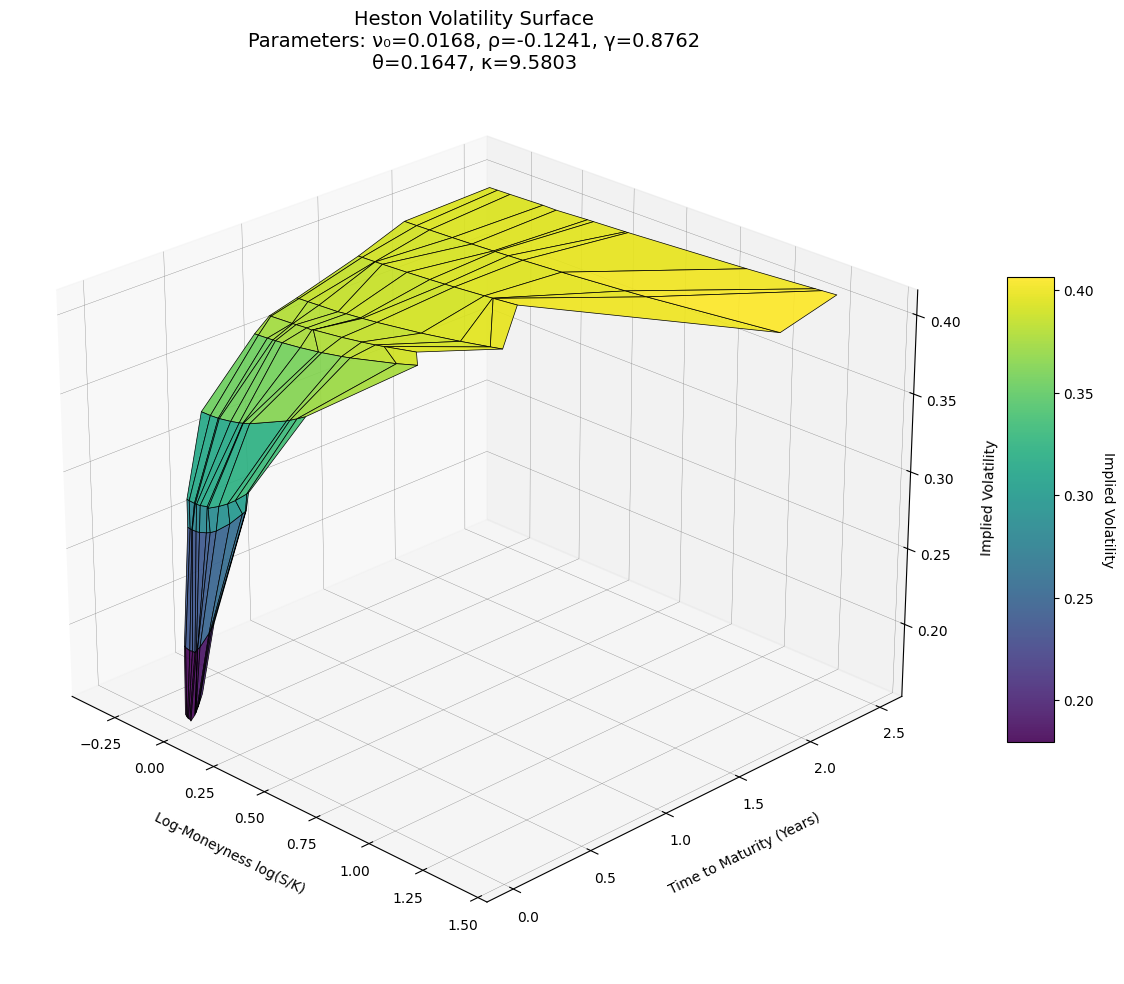

In [15]:
# PLOT ONE IMPLIED VOLATILITY SURFACE
from mpl_toolkits.mplot3d import Axes3D


def plot_heston_vol_surface(data, ivs, param_set_idx=0, points_per_set=143, 
                           use_log_moneyness=True, show_implied_vols=True):
    """
    Plots a 3D volatility surface for a specific Heston parameter set.
    
    Args:
        data: Full dataset array (N*143,7) with columns [v0,rho,gamma,theta,kappa,strike,maturity]
        ivs: Implied volatilities array (N*143,)
        param_set_idx: Index of parameter set to visualize (default: 0)
        points_per_set: Number of options per parameter set (default: 143)
        use_log_moneyness: Whether to plot log(K/S0) instead of strikes (default: True)
        show_implied_vols: Whether to show IV values on hover (default: True)
    """
    # Extract the specific parameter set's options
    start_idx = param_set_idx * points_per_set
    end_idx = (param_set_idx + 1) * points_per_set
    param_set = data[start_idx:end_idx]
    param_ivs = ivs[start_idx:end_idx]
    
    # Get parameters for title
    params = param_set[0, :5]
    
    # Prepare grid structure (11 maturities × 13 strikes)
    strikes = param_set[:, 5].reshape(11, 13)
    maturities = param_set[:, 6].reshape(11, 13)
    iv_matrix = param_ivs.reshape(11, 13)
    
    # Calculate log-moneyness if requested
    if use_log_moneyness:
        x_axis = np.log(S0/strikes)  # log(S0/K)
        x_label = "Log-Moneyness log(S/K)"
    else:
        x_axis = strikes
        x_label = "Strike Price K"
    
    # Create 3D plot
    fig = plt.figure(figsize=(14, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    # Surface plot
    surf = ax.plot_surface(x_axis, maturities, iv_matrix, 
                          cmap='viridis', edgecolor='k', alpha=0.9,
                          linewidth=0.5, antialiased=True)
    
    # Add colorbar
    cbar = fig.colorbar(surf, shrink=0.5, aspect=10)
    cbar.set_label('Implied Volatility', rotation=270, labelpad=15)
    
    # Customize view angle
    ax.view_init(elev=25, azim=-45)
    
    # Labels and title
    ax.set_xlabel(x_label, labelpad=12)
    ax.set_ylabel('Time to Maturity (Years)', labelpad=12)
    ax.set_zlabel('Implied Volatility', labelpad=12)
    
    title = (f"Heston Volatility Surface\n"
             f"Parameters: ν₀={params[0]:.4f}, ρ={params[1]:.4f}, γ={params[2]:.4f}\n"
             f"θ={params[3]:.4f}, κ={params[4]:.4f}")
    plt.title(title, y=1.05, fontsize=14)
    
    # Add grid lines
    ax.xaxis._axinfo["grid"].update({"linewidth":0.25, "color":"gray"})
    ax.yaxis._axinfo["grid"].update({"linewidth":0.25, "color":"gray"})
    ax.zaxis._axinfo["grid"].update({"linewidth":0.25, "color":"gray"})
    
    # Add strike values on x-axis (every 2nd strike to avoid clutter)
    if not use_log_moneyness:
        ax.set_xticks(strikes[0, ::2])
        ax.set_xticklabels([f"{k:.2f}" for k in strikes[0, ::2]], rotation=45)
    
    plt.tight_layout()
    plt.show()

# Example usage:
# Assuming you have loaded your data:
# data = np.loadtxt("HestonRandomGridsDataset.csv", delimiter=",")
# params = data[:, :5]
# strikes = data[:, 5]
# maturities = data[:, 6]
# ivs = data[:, 7]

# Plot with log-moneyness
plot_heston_vol_surface(random_grid_data, implied_vols, param_set_idx=0, use_log_moneyness=True)

In [14]:
# Save the entire dataset (useful)
def save_heston_dataset(clean_data , clean_ivs, filename="HestonRandomGridsDataset.csv"):
    """
    Save the complete Heston dataset (parameters + strikes + maturities + implied vols) to a CSV file.
    
    Args:
        random_grid_data: numpy array of shape (N, 7) with columns [v0, rho, gamma, theta, kappa, strike, maturity]
        implied_vols: numpy array of shape (N,) with implied volatilities
        filename: output CSV filename (default: "HestonRandomGridsDataset.csv")
    
    Returns:
        None (saves a CSV file)
    """
    # Convert to DataFrame for clean CSV export
    df = pd.DataFrame(
        data=np.column_stack((clean_data, clean_ivs)),
        columns=["v0", "rho", "gamma", "theta", "kappa", "strike", "maturity", "implied_vol"]
    )
    
    # Optional: Remove rows with NaN implied volatilities
    df_clean = df.dropna(subset=["implied_vol"])
    
    # Save to CSV
    df_clean.to_csv(filename, index=False)
    print(f"Dataset successfully saved to {filename}")
    print(f"Shape: {df_clean.shape}, {len(df) - len(df_clean)} rows removed due to NaN values")

# Example usage:
save_heston_dataset(clean_data, clean_ivs)

Dataset successfully saved to HestonRandomGridsDataset.csv
Shape: (1950663, 8), 0 rows removed due to NaN values


In [16]:
# DISCARD LAST ROWS TO HAVE 12000 PARAMETERS SETS AND RENAME DATASET
#===================================================================

def truncate_heston_dataset(clean_data, clean_ivs, target_sets=12000, points_per_set=143):
    """
    Truncates the Heston dataset to exactly 12,000 complete parameter sets.
    
    Args:
        clean_data: Full cleaned data array (shape: [N*143, 7])
        clean_ivs: Corresponding implied volatilities (shape: [N*143,])
        target_sets: Number of parameter sets to keep (default: 12000)
        points_per_set: Options per parameter set (default: 143)
        
    Returns:
        random_grid_data: Truncated data array (shape: [12000*143, 7])
        implied_vols: Corresponding IVs (shape: [12000*143,])
    """
    # Calculate total points to keep
    total_points = target_sets * points_per_set
    
    # Verify we have enough data
    if len(clean_data) < total_points:
        raise ValueError(f"Not enough data. Needed: {total_points}, Available: {len(clean_data)}")
    
    # Truncate the arrays
    random_grid_data = clean_data[:total_points]
    implied_vols = clean_ivs[:total_points]
    
    # Final verification
    num_sets = len(random_grid_data) // points_per_set
    assert num_sets == target_sets, f"Expected {target_sets} sets, got {num_sets}"
    assert len(random_grid_data) == len(implied_vols), "Data and IVs length mismatch"
    
    print(f"Successfully truncated to {target_sets} parameter sets")
    print(f"Final shapes - Data: {random_grid_data.shape}, IVs: {implied_vols.shape}")
    
    return random_grid_data, implied_vols

# Usage example:
random_grid_data, implied_vols = truncate_heston_dataset(clean_data, clean_ivs)

# Verify the first and last parameter sets:
print("\nFirst set parameters:", random_grid_data[0, :5])
print("Last set parameters:", random_grid_data[-143, :5])  # First row of last set

Successfully truncated to 12000 parameter sets
Final shapes - Data: (1716000, 7), IVs: (1716000,)

First set parameters: [ 0.01683994 -0.12410636  0.87622854  0.16472127  9.58028822]
Last set parameters: [ 0.03092108 -0.86221837  0.37087682  0.03024533  5.48019037]


# Train-val-test split
In the following snippet we perform the usual trainining-validation-test split, but we need to be careful, this split is not completely random. In fact we need to handle the dataset not at a single-option level, but to parameter set level, meaning that we need to **preserve the integrity** of each surface referring to a parameter set, ESPECIALLY on the test set, where we will calibrate each IV surface.

In [17]:
def split_parameter_blocks(X_pw, y_pw, points_per_sample=143, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15, random_seed=42):
    """
    Splits the dataset into train/val/test sets while keeping all strike-maturity combinations
    for each Heston parameter set together (no mixing of parameter sets across splits).
    
    Args:
        X_pw: Pointwise features array (n_samples*n_points, 7) [v0,rho,gamma,theta,kappa,strike,maturity]
        y_pw: Pointwise target array (n_samples*n_points,) [implied_vols]
        points_per_sample: Number of points per parameter set (default 143)
        train_ratio: Fraction of parameter sets for training
        val_ratio: Fraction of parameter sets for validation
        test_ratio: Fraction of parameter sets for testing
        random_seed: Optional random seed for reproducibility
        
    Returns:
        Tuple of (X_train, y_train), (X_val, y_val), (X_test, y_test)
    """
    # Verify ratios sum to 1
    assert np.isclose(train_ratio + val_ratio + test_ratio, 1.0), "Ratios must sum to 1"
    
    # Calculate number of unique parameter sets
    n_samples = len(X_pw) // points_per_sample
    assert len(X_pw) == n_samples * points_per_sample, "Data length doesn't match expected samples*points"
    
    print(f"Total parameter sets: {n_samples}")
    print(f"Points per parameter set: {points_per_sample}")
    print(f"Total points: {len(X_pw)}")
    
    # Create sample indices (0,0,0..., 1,1,1..., etc.)
    sample_indices = np.repeat(np.arange(n_samples), points_per_sample)
    
    # Split parameter set indices (not the points themselves)
    np.random.seed(random_seed)
    shuffled_indices = np.random.permutation(n_samples)
    
    train_end = int(n_samples * train_ratio)
    val_end = train_end + int(n_samples * val_ratio)
    
    train_samples = shuffled_indices[:train_end]
    val_samples = shuffled_indices[train_end:val_end]
    test_samples = shuffled_indices[val_end:]
    
    print(f"\nSplit counts:")
    print(f"Training parameter sets: {len(train_samples)} ({len(train_samples)/n_samples:.1%})")
    print(f"Validation parameter sets: {len(val_samples)} ({len(val_samples)/n_samples:.1%})")
    print(f"Test parameter sets: {len(test_samples)} ({len(test_samples)/n_samples:.1%})")
    
    # Create masks for each split
    train_mask = np.isin(sample_indices, train_samples)
    val_mask = np.isin(sample_indices, val_samples)
    test_mask = np.isin(sample_indices, test_samples)
    
    # Apply masks to get splits
    X_train, y_train = X_pw[train_mask], y_pw[train_mask]
    X_val, y_val = X_pw[val_mask], y_pw[val_mask]
    X_test, y_test = X_pw[test_mask], y_pw[test_mask]
    
    # Verification checks
    assert len(X_train) == len(train_samples) * points_per_sample
    assert len(X_val) == len(val_samples) * points_per_sample
    assert len(X_test) == len(test_samples) * points_per_sample
    
    # Verify no overlapping parameter sets between splits
    assert len(set(train_samples) & set(val_samples)) == 0
    assert len(set(train_samples) & set(test_samples)) == 0
    assert len(set(val_samples) & set(test_samples)) == 0
    
    print("\nVerification passed - all parameter sets remain intact in their respective splits")
    
    return (X_train, y_train), (X_val, y_val), (X_test, y_test)


# Example usage:
(X_train, y_train), (X_val, y_val), (X_test, y_test) = \
    split_parameter_blocks(random_grid_data, implied_vols, points_per_sample=143,
                          train_ratio=0.7, val_ratio=0.15, test_ratio=0.15,
                          random_seed=42)

# Verification prints
print("\n=== Split Shapes ===")
print(f"Training set: {X_train.shape} (should be ~{len(random_grid_data)*0.7:.0f} points)")
print(f"Validation set: {X_val.shape} (should be ~{len(random_grid_data)*0.15:.0f} points)")
print(f"Test set: {X_test.shape} (should be ~{len(random_grid_data)*0.15:.0f} points)")

print("\n=== Sample Distribution ===")
print(f"First training sample params: {X_train[0][:5]}")
print(f"First validation sample params: {X_val[0][:5]}")
print(f"First test sample params: {X_test[0][:5]}")

Total parameter sets: 12000
Points per parameter set: 143
Total points: 1716000

Split counts:
Training parameter sets: 8400 (70.0%)
Validation parameter sets: 1800 (15.0%)
Test parameter sets: 1800 (15.0%)

Verification passed - all parameter sets remain intact in their respective splits

=== Split Shapes ===
Training set: (1201200, 7) (should be ~1201200 points)
Validation set: (257400, 7) (should be ~257400 points)
Test set: (257400, 7) (should be ~257400 points)

=== Sample Distribution ===
First training sample params: [ 0.01683994 -0.12410636  0.87622854  0.16472127  9.58028822]
First validation sample params: [ 0.03112004 -0.16701144  0.75651196  0.11783497  2.63732937]
First test sample params: [ 0.01585444 -0.2661654   0.14058553  0.16583152  7.1904943 ]


In [ ]:
# NOW WE CAN SHUFFLE RANDOMLY THE TRAINING AND THE VALIDATION SET AS WE NEED TO APPROXIMATE THE OPTION PRICING FUNCTION
# ======================================================================================
def shuffle_within_splits(X_train, y_train, X_val, y_val, random_seed=42):
    """
    Shuffles data points within training and validation sets while preserving:
    - The test set remains unchanged (critical for calibration)
    - All columns stay aligned during shuffling
    
    Args:
        X_train: Training features (n_points, 7)
        y_train: Training targets (n_points,)
        X_val: Validation features (n_points, 7)
        y_val: Validation targets (n_points,)
        random_seed: Optional seed for reproducibility
        
    Returns:
        Shuffled versions of all training/validation inputs (X_train, y_train, X_val, y_val)
    """
    np.random.seed(random_seed)
    
    # Create shuffling indices
    train_shuffle_idx = np.random.permutation(len(X_train))
    val_shuffle_idx = np.random.permutation(len(X_val))
    
    # Apply shuffling
    X_train_shuffled = X_train[train_shuffle_idx]
    y_train_shuffled = y_train[train_shuffle_idx]
    X_val_shuffled = X_val[val_shuffle_idx]
    y_val_shuffled = y_val[val_shuffle_idx]
    
    # Verification
    print("\n=== Shuffling Verification ===")
    print("Training set order changed:", not np.array_equal(X_train_shuffled[:5], X_train[:5]))
    print("Validation set order changed:", not np.array_equal(X_val_shuffled[:5], X_val[:5]))
    print("Shape consistency check:")
    print(f"- X_train: {X_train.shape} -> {X_train_shuffled.shape}")
    print(f"- y_train: {y_train.shape} -> {y_train_shuffled.shape}")
    print(f"- X_val: {X_val.shape} -> {X_val_shuffled.shape}")
    print(f"- y_val: {y_val.shape} -> {y_val_shuffled.shape}")
    
    return X_train_shuffled, y_train_shuffled, X_val_shuffled, y_val_shuffled


def verify_shuffling_integrity(original_X, shuffled_X, set_name):
    """
    Verifies that shuffling preserved all parameter sets and their points
    by checking unique parameter combinations in first 5 columns (Heston params)
    """
    # Get unique parameter sets from first 5 columns
    original_params = {tuple(x) for x in original_X[:, :5]}
    shuffled_params = {tuple(x) for x in shuffled_X[:, :5]}
    
    # Check all original parameter sets are present
    assert original_params == shuffled_params, f"{set_name} lost parameter sets!"
    
    # Check point counts per parameter set
    from collections import defaultdict
    original_counts = defaultdict(int)
    shuffled_counts = defaultdict(int)
    
    for params in original_X[:, :5]:
        original_counts[tuple(params)] += 1
    for params in shuffled_X[:, :5]:
        shuffled_counts[tuple(params)] += 1
        
    assert original_counts == shuffled_counts, f"{set_name} point counts changed!"
    
    print(f"{set_name} verification passed - all parameter sets preserved")


# Example usage:
print("=== Pre-shuffling ===")
print(f"Original training order (first 5 strikes): {X_train[:5, 5]}")
print(f"Original validation order (first 5 strikes): {X_val[:5, 5]}")

X_train_shuffled, y_train_shuffled, X_val_shuffled, y_val_shuffled = \
    shuffle_within_splits(X_train, y_train, X_val, y_val, random_seed=42)

print("\n=== Post-shuffling ===")
print(f"Shuffled training order (first 5 strikes): {X_train_shuffled[:5, 5]}")
print(f"Shuffled validation order (first 5 strikes): {X_val_shuffled[:5, 5]}")

# Integrity check
print("\n=== Integrity Verification ===")
verify_shuffling_integrity(X_train, X_train_shuffled, "Training set")
verify_shuffling_integrity(X_val, X_val_shuffled, "Validation set")

X_train = X_train_shuffled
y_train = y_train_shuffled
X_val = X_val_shuffled
y_val = y_val_shuffled



=== Shuffling Verification ===
Training set order changed: True
Validation set order changed: True
DataFrame-array alignment check:
- Training: True
- Validation: True

=== Post-Shuffling Integrity Check ===
Training set verification passed - all parameter sets preserved
Validation set verification passed - all parameter sets preserved

=== Training Set Order (Before vs After) ===
Original first 5 samples:
   sample_idx  strike  maturity
0           0     0.5       0.1
1           0     0.6       0.1
2           0     0.7       0.1
3           0     0.8       0.1
4           0     0.9       0.1

Shuffled first 5 samples:
   sample_idx  strike  maturity
0        7885     1.0       0.6
1        6611     1.1       1.2
2        8698     0.5       0.9
3        8246     1.3       0.3
4        4386     1.1       2.0


# Scaling:
Now we can finally scale both the parameters as shown below and the implied volatilities, this will improve the numerical stability of the training and calibration procedure.

# Model Parameters ${\theta}_{i=1,..,5}\to scale(\theta_i)\in[-1,1]$
## $scale(\theta_i)=\frac{2\theta_i-(\theta_i^{max}+\theta_i^{min})}{\theta_i^{max}-\theta_i^{min}},\quad i \in |\Theta|$

# Implied volatilities
## $$scale(\sigma^{BS}_{i,j})=\frac{\sigma^{BS}_{i,j}-\mathbb{E}[\sigma^{BS}_{i,j}]}{std(\sigma^{BS}_{i,j})},\quad i\in\text{Maturities},\; j\in \text{Strikes}$$

In [18]:
from sklearn.preprocessing import StandardScaler
from tabulate import tabulate

# =================================================================
# 1. IMPLIED VOLATILITY SCALING (StandardScaler)
# =================================================================
scaler_yy = StandardScaler()

# Reshape y arrays to 2D if needed (StandardScaler expects 2D input)
y_train = y_train.reshape(-1, 1)
y_val = y_val.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

# Apply scaling
y_train_transform = scaler_yy.fit_transform(y_train)  # Compute μ and σ on training set
y_val_transform = scaler_yy.transform(y_val)          # Use same μ and σ
y_test_transform = scaler_yy.transform(y_test)        # Use same μ and σ

# Inverse transform function
def yinversetransform(y_scaled):
    """Convert scaled volatilities back to original scale"""
    return scaler_yy.inverse_transform(y_scaled)

# =================================================================
# 2. HESTON PARAMETERS SCALING (Custom [-1,1] scaling)
# =================================================================
# Define Heston parameter's upper and lower bounds
#v0    ∈ [0.0001, 0.04]        (initial variance)
#rho   ∈ [-0.95, -0.1]         (spot-vol correlation)
#gamma ∈ [0.01, 1.0]           (vol of variance)
#theta ∈ [0.01, 0.2]           (mean reverting level of variance)
#kappa ∈ [1, 10.0]             (speed of mean reversion)
#parameters order is: [v0, rho, gamma, theta, kappa]

ub=np.array([0.04,-0.1,1.0,0.2,10.0])
lb=np.array([0.0001,-0.95,0.01,0.01,1.0])

def myscale(x):
    """
    Scale Heston parameters to [-1,1] range while preserving strike/maturity
    Args:
        x: Input array (n_points, 7) where cols 0-4 are Heston params, 5-6 are strike/maturity
    Returns:
        Scaled array with same shape, only Heston params transformed
    """
    x_scaled = x.copy()
    # Only scale first 5 columns (Heston params)
    for i in range(5):
        x_scaled[:,i] = (2*x[:,i] - (ub[i] + lb[i])) / (ub[i] - lb[i])
    return x_scaled

def myinverse(x_scaled):
    """
    Convert scaled Heston params back to original scale
    Args:
        x_scaled: Scaled array (n_points, 7)
    Returns:
        Array with Heston params in original scale
    """
    x_original = x_scaled.copy()
    for i in range(5):
        x_original[:,i] = x_scaled[:,i] * (ub[i] - lb[i]) * 0.5 + (ub[i] + lb[i]) * 0.5
    return x_original

# Apply scaling (only to Heston params, leave strike/maturity unchanged)
x_train_transform = myscale(X_train)
x_val_transform = myscale(X_val)
x_test_transform = myscale(X_test)

# =================================================================
# VERIFICATION
# =================================================================
def verify_scaling(original, scaled, param_names):
    """Check scaling was correctly applied"""
    print("\nScaling verification for:", param_names)
    for i in range(5):  # Only check Heston params
        orig_min, orig_max = original[:,i].min(), original[:,i].max()
        scaled_min, scaled_max = scaled[:,i].min(), scaled[:,i].max()
        print(f"{param_names[i]:<6}: [{orig_min:.4f},{orig_max:.4f}] -> [{scaled_min:.4f},{scaled_max:.4f}]")
    
    # Verify strike/maturity unchanged
    assert np.allclose(original[:,5:], scaled[:,5:]), "Strike/maturity values were modified!"

print("=== Scaling Verification ===")
verify_scaling(X_train, x_train_transform, ["ν₀", "ρ", "γ", "θ", "k"])

# =================================================================
# DATASET SUMMARY
# =================================================================
shape_data = [
    ["Training", x_train_transform.shape, y_train_transform.shape],
    ["Validation", x_val_transform.shape, y_val_transform.shape], 
    ["Test", x_test_transform.shape, y_test_transform.shape]
]

print("\n=== Scaled Dataset Shapes ===")
print(tabulate(shape_data,
               headers=["Split", "Features Shape", "Target Shape"],
               tablefmt="grid",
               stralign="center"))

print("\nKey Notes:")
print("- Only Heston parameters (first 5 columns) were scaled to [-1,1] range")
print("- Strike and maturity values (last 2 columns) remain in original scale")
print("- Implied volatilities were standardized using z-score scaling")

=== Scaling Verification ===

Scaling verification for: ['ν₀', 'ρ', 'γ', 'θ', 'k']
ν₀    : [0.0001,0.0400] -> [-1.0000,0.9994]
ρ     : [-0.9499,-0.1000] -> [-0.9997,1.0000]
γ     : [0.0100,1.0000] -> [-1.0000,0.9999]
θ     : [0.0101,0.2000] -> [-0.9994,1.0000]
k     : [1.0023,9.9986] -> [-0.9995,0.9997]

=== Scaled Dataset Shapes ===
+------------+------------------+----------------+
|   Split    |  Features Shape  |  Target Shape  |
+============+==================+================+
|  Training  |   (1201200, 7)   |  (1201200, 1)  |
+------------+------------------+----------------+
| Validation |   (257400, 7)    |  (257400, 1)   |
+------------+------------------+----------------+
|    Test    |   (257400, 7)    |  (257400, 1)   |
+------------+------------------+----------------+

Key Notes:
- Only Heston parameters (first 5 columns) were scaled to [-1,1] range
- Strike and maturity values (last 2 columns) remain in original scale
- Implied volatilities were standardized using z-sc

# CaNN: Calibration Neural Network
Step 1: *Forward Pass*
Now we can train the network to learn the **mapping** from: Heston + **random** contract parameters -> implied volatility. we can set up our neural network composed of:

- **4 hidden layers**, each with **30 neurons**  
- **output layer** with 1 neuron, here we select a **linear** activation function because of the preprocessing of implied volatilities
- **Activation function**: **Elu** , $\sigma_{Elu}=\alpha(e^x -1)$ in all the layers, its smoothness is crucial for the approximation of the Loss function
- **Batch size**: **1024**  
- **Optimizer**: **Adam**  
- **Early stopping**: with patience set to 30 epochs, maximum number of epochs being 400
- **Loss**: MSE

In [20]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping

# Set precision to float64
tf.keras.backend.set_floatx('float64')
tf.random.set_seed(42)  # For consistent initialization

# Build the model
inputs = Input(shape=(7,), name='input_layer')
x1 = Dense(30, activation='elu', name='hidden_1')(inputs)
x2 = Dense(30, activation='elu', name='hidden_2')(x1) 
x3 = Dense(30, activation='elu', name='hidden_3')(x2) 
x4 = Dense(30, activation='elu', name='hidden_4')(x3)
outputs = Dense(1, activation='linear', name='output_layer')(x4)

modelrandom = Model(inputs=inputs, outputs=outputs, name = 'random_point_model')
modelrandom.summary()

Model: "random_point_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 7)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_1 (Dense)                │ (None, 30)             │           240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_2 (Dense)                │ (None, 30)             │           930 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_3 (Dense)                │ (None, 30)             │           930 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_4 (Dense)                │ (None, 30)             │           930 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │            31 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,061 (23.91 KB)

 Trainable params: 3,061 (23.91 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/400
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.1932 - val_loss: 0.0122
Epoch 2/400
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0093 - val_loss: 0.0060
Epoch 3/400
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0053 - val_loss: 0.0037
Epoch 4/400
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0035 - val_loss: 0.0030
Epoch 5/400
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0026 - val_loss: 0.0023
Epoch 6/400
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0022 - val_loss: 0.0019
Epoch 7/400
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0019 - val_loss: 0.0017
Epoch 8/400
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0017 - val_loss: 0.0014
Epoch 9/400
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0015 - val_loss: 0.0013
Epoch 10/400
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 11/400
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 12/400
1174/1

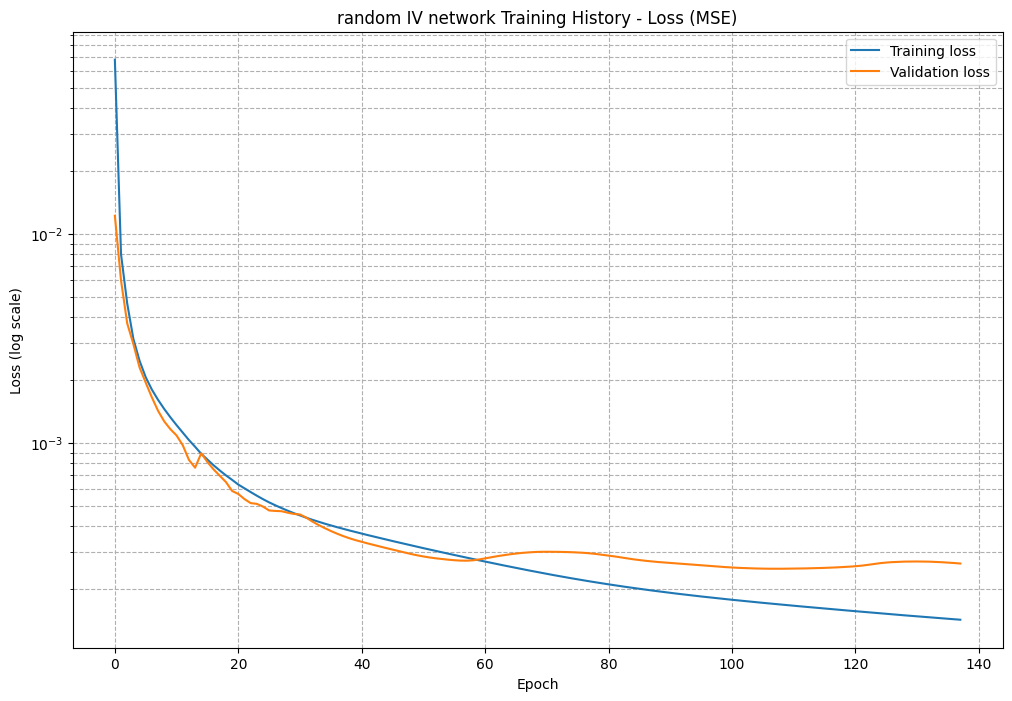


Final Training Loss: 1.4269e-04
Final Validation Loss: 2.6496e-04


In [21]:
import time
# EarlyStopping callback
earlystop = EarlyStopping(
    monitor='val_loss', 
    patience=30,       
    verbose=1,       
    restore_best_weights=True  # Restore the best model weights
)

# Callbacks
#reduce_lr = ReduceLROnPlateau(
#        monitor='val_loss',
#        factor=0.5,
#        patience=20,
#        min_lr=5e-5,
 #       verbose=1
 #   )

# Compile the model
modelrandom.compile(loss="mse", optimizer="adam")

# Train the model
start=time.time()
history = modelrandom.fit(
    x_train_transform, 
    y_train_transform, 
    batch_size=1024,
    validation_data=(x_val_transform, y_val_transform),
    epochs=400, 
    verbose=1, 
    shuffle=True, 
    callbacks=[earlystop]
)
end=time.time()
training_time=(end-start)
print("Training time :" ,training_time , "s" )

# Plot training history
plt.figure(figsize=(12, 8))  
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.yscale('log')
plt.title('random IV network Training History - Loss (MSE)')
plt.xlabel('Epoch')
plt.ylabel('Loss (log scale)')
plt.legend()
plt.grid(True, which="both", ls="--")
plt.show()

# Print final metrics
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]
print(f"\nFinal Training Loss: {final_train_loss:.4e}")
print(f"Final Validation Loss: {final_val_loss:.4e}")

# Evaluate the map on test data

8044/8044 ━━━━━━━━━━━━━━━━━━━━ 27s 3ms/step

=== Performance on Standardized Scale ===
- MSE: 0.000250
- RMSE: 0.015798
- MAE: 0.009916

=== Performance on Original Scale ===
- MSE: 0.000002
- RMSE: 0.001323 (0.46% of mean IV)
- MAE: 0.000830 (0.29% of mean IV)


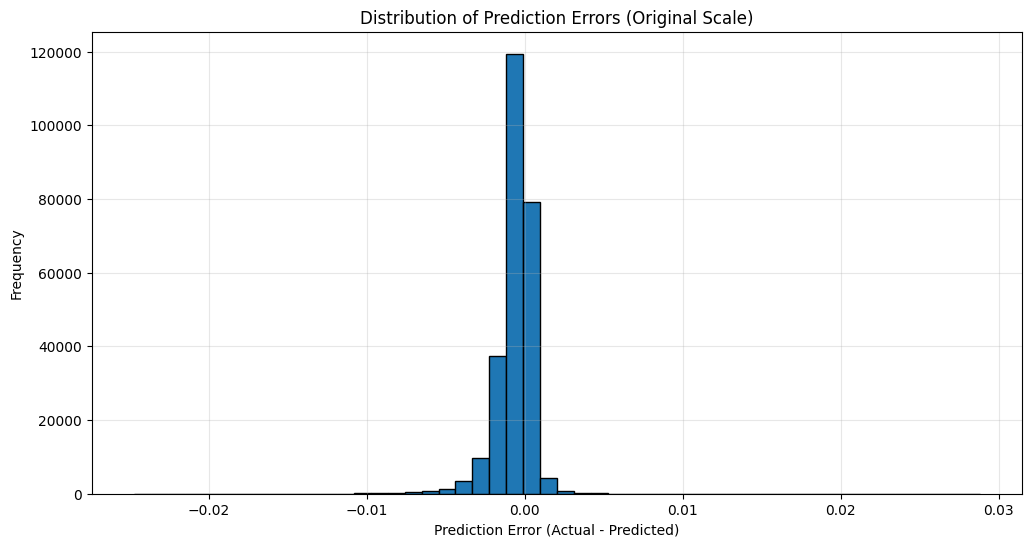

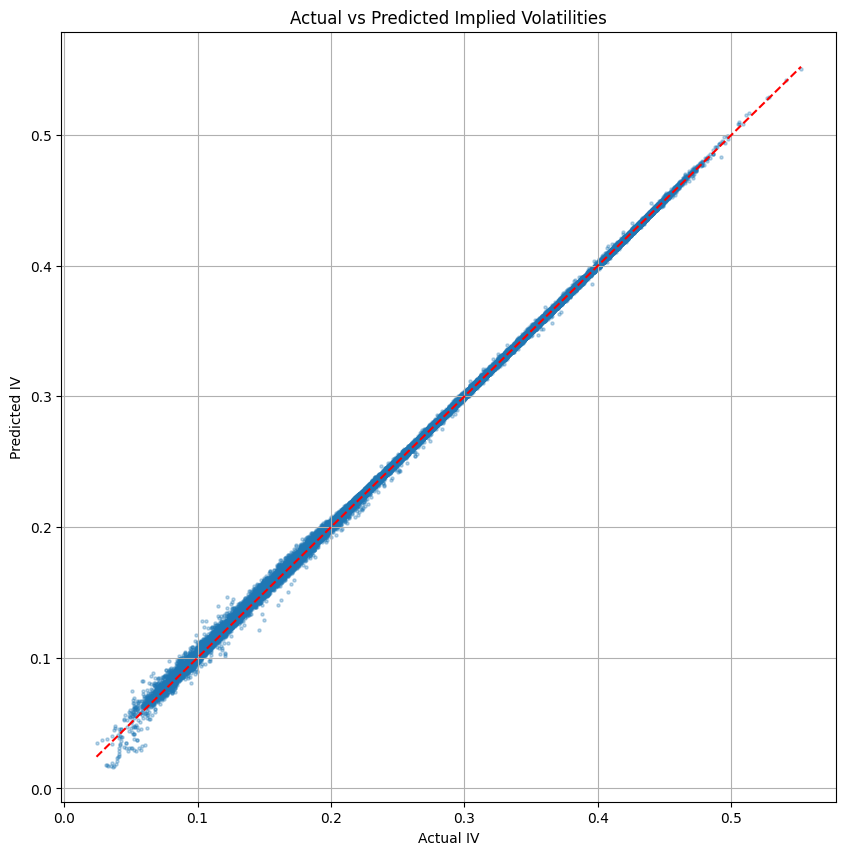

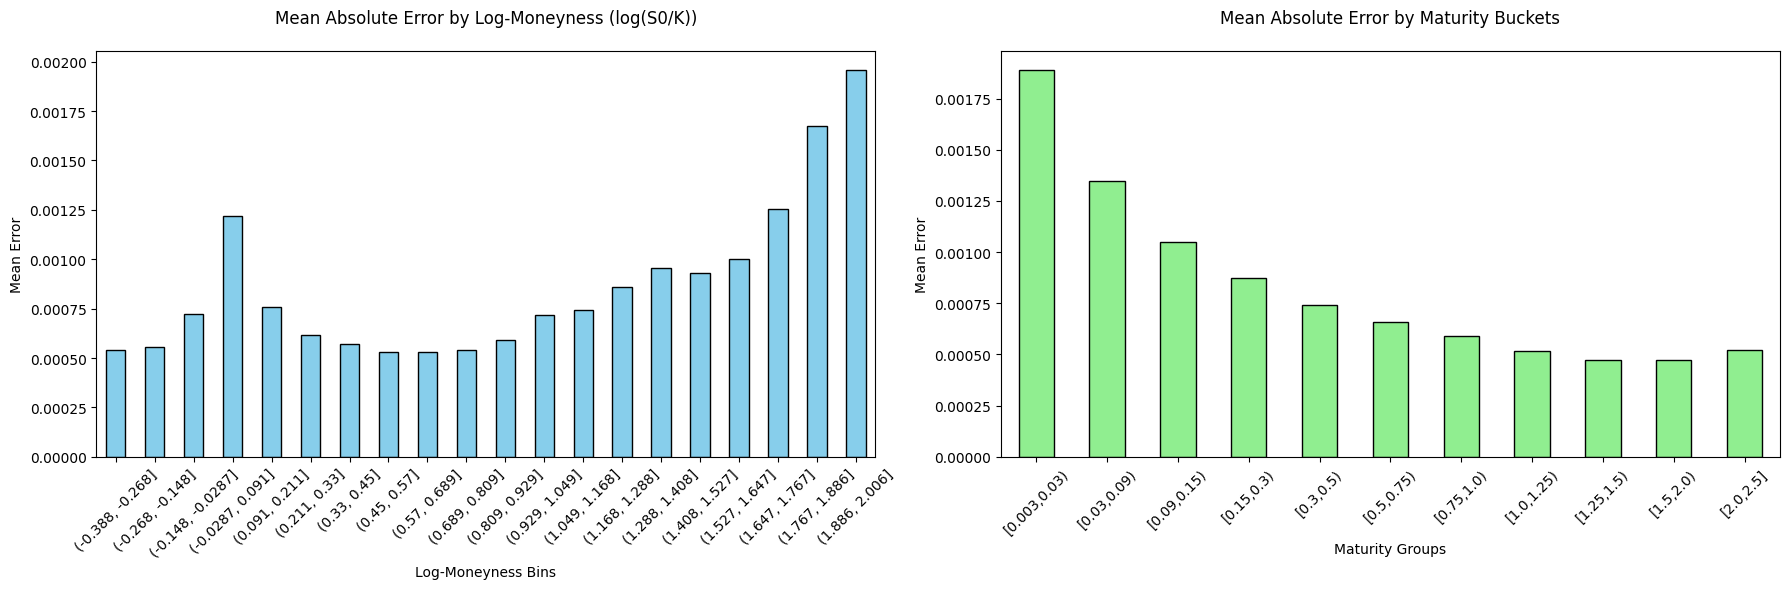


=== MAE by Maturity Bucket ===
[0.003,0.03): 0.001889
[0.03,0.09): 0.001348
[0.09,0.15): 0.001049
[0.15,0.3): 0.000875
[0.3,0.5): 0.000741
[0.5,0.75): 0.000658
[0.75,1.0): 0.000589
[1.0,1.25): 0.000516
[1.25,1.5): 0.000473
[1.5,2.0): 0.000472
[2.0,2.5]: 0.000522


In [26]:
# Calculate predictions on test set
y_pred_transformed = modelrandom.predict(x_test_transform, verbose=1)

# 1) Evaluation on transformed scale (standardized volatilities)
mse_transformed = np.mean(np.square(y_test_transform - y_pred_transformed))
rmse_transformed = np.sqrt(mse_transformed)
mae_transformed = np.mean(np.abs(y_test_transform - y_pred_transformed))

print("\n=== Performance on Standardized Scale ===")
print(f"- MSE: {mse_transformed:.6f}")
print(f"- RMSE: {rmse_transformed:.6f}")
print(f"- MAE: {mae_transformed:.6f}")

# 2) Evaluation on original scale (implied volatilities)
y_pred_original = yinversetransform(y_pred_transformed)

mse_original = np.mean(np.square(y_test - y_pred_original))
rmse_original = np.sqrt(mse_original)
mae_original = np.mean(np.abs(y_test - y_pred_original))
mean_iv = np.mean(y_test)  # Reference for relative error

print("\n=== Performance on Original Scale ===")
print(f"- MSE: {mse_original:.6f}")
print(f"- RMSE: {rmse_original:.6f} ({(rmse_original/mean_iv)*100:.2f}% of mean IV)")
print(f"- MAE: {mae_original:.6f} ({(mae_original/mean_iv)*100:.2f}% of mean IV)")

# 3) Error distribution analysis
errors = y_test - y_pred_original
plt.figure(figsize=(12, 6))
plt.hist(errors, bins=50, edgecolor='black')
plt.title('Distribution of Prediction Errors (Original Scale)')
plt.xlabel('Prediction Error (Actual - Predicted)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.show()

# 4) Scatter plot of predictions vs actual
plt.figure(figsize=(10, 10))
plt.scatter(y_test, y_pred_original, alpha=0.3, s=5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title('Actual vs Predicted Implied Volatilities')
plt.xlabel('Actual IV')
plt.ylabel('Predicted IV')
plt.grid(True)
plt.show()

# 5) Error by moneyness and maturity (adapted version without df_test)
log_moneyness = np.log(S0 / X_test[:, 5]) 
maturities = X_test[:, 6] 

# Define maturity buckets exactly as in random grid generation
maturity_bins = [0.003, 0.03, 0.09, 0.15, 0.3, 0.5, 0.75, 1.0, 1.25, 1.5, 2.0, 2.5]
maturity_labels = [
    '[0.003,0.03)', '[0.03,0.09)', '[0.09,0.15)', '[0.15,0.3)',
    '[0.3,0.5)', '[0.5,0.75)', '[0.75,1.0)', '[1.0,1.25)',
    '[1.25,1.5)', '[1.5,2.0)', '[2.0,2.5]'
]

# Create moneyness bins (20 equally spaced bins between min and max)
moneyness_bins = np.linspace(log_moneyness.min(), log_moneyness.max(), 21)

# Calculate mean errors
moneyness_groups = pd.cut(log_moneyness, bins=moneyness_bins)
maturity_groups = pd.cut(maturities, bins=maturity_bins, labels=maturity_labels)

mae = np.abs(errors).reshape(-1)
error_by_moneyness = pd.Series(mae).groupby(moneyness_groups).mean()
error_by_maturity = pd.Series(mae).groupby(maturity_groups).mean()

# Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# Moneyness plot
error_by_moneyness.plot(kind='bar', ax=ax1, color='skyblue', edgecolor='black')
ax1.set_title('Mean Absolute Error by Log-Moneyness (log(S0/K))', pad=20)
ax1.set_xlabel('Log-Moneyness Bins')
ax1.set_ylabel('Mean Error')
ax1.tick_params(axis='x', rotation=45)

# Maturity plot
error_by_maturity.plot(kind='bar', ax=ax2, color='lightgreen', edgecolor='black')
ax2.set_title('Mean Absolute Error by Maturity Buckets', pad=20)
ax2.set_xlabel('Maturity Groups')
ax2.set_ylabel('Mean Error')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Additional: Print MAE for each maturity bucket
print("\n=== MAE by Maturity Bucket ===")
for maturity, mae in error_by_maturity.items():
    print(f"{maturity}: {mae:.6f}")

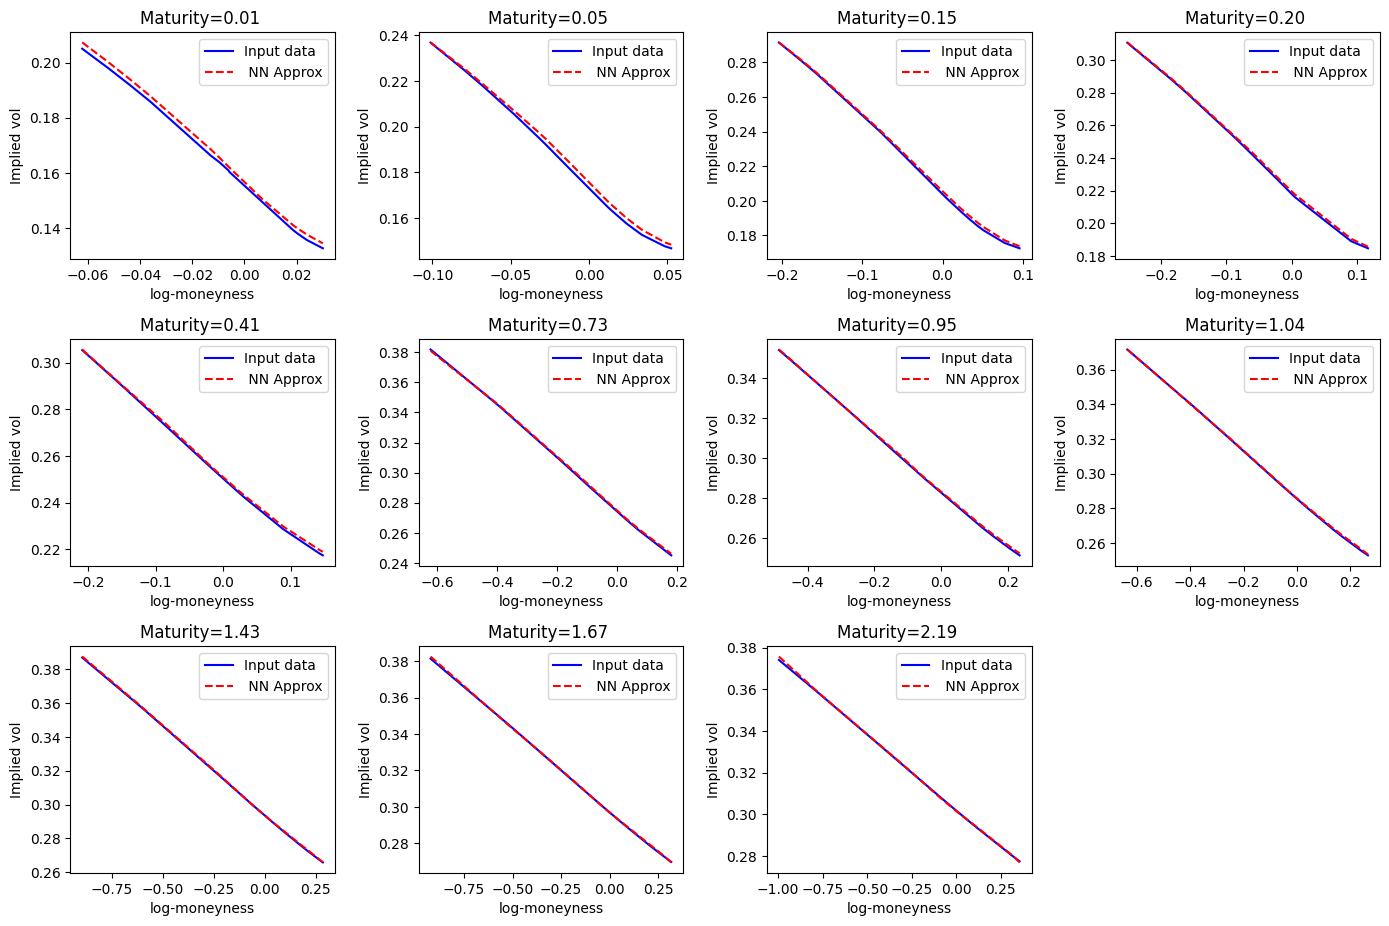

In [30]:
# FINALLY WE PLOT SAMPLE SMILES OF THE TEST SET

# Take a sample index from the test set
sample_ind = 512*143
sample_X = X_test[sample_ind:sample_ind+143]  # Get corresponding X_test rows
y_sample = y_test[sample_ind:sample_ind+143].squeeze().T             #take corresponding (not processed)test sample
prediction = y_pred_original[sample_ind:sample_ind+143].squeeze().T  #take corresponding (converted)prediction

S0=1.0  #specify spot price
strikes_dim = 13
maturities_dim = 11

plt.figure(1,figsize=(14,12))
for i in range(maturities_dim):
    plt.subplot(4,4,i+1)
    
    plt.plot(np.log(sample_X[i*strikes_dim:(i+1)*strikes_dim,5]/S0),y_sample[i*strikes_dim:(i+1)*strikes_dim],'b',label="Input data")
    plt.plot(np.log(sample_X[i*strikes_dim:(i+1)*strikes_dim,5]/S0),prediction[i*strikes_dim:(i+1)*strikes_dim],'--r',label=" NN Approx")

    
    plt.title("Maturity=%1.2f "%sample_X[i*strikes_dim,6])
    plt.xlabel("log-moneyness")
    plt.ylabel("Implied vol")
    
    plt.legend()
plt.tight_layout()
plt.show()

# Optimizing the training
Numpy Implementation of the Neural Network tends to be faster than Keras

In [31]:
import scipy.optimize

# =====================================================================================
# EXTRACT TRAINED WEIGHTS FROM KERAS MODEL
# =====================================================================================

def extract_weights_from_keras_model(model):
    weights_and_biases = []
    for layer in model.layers:
        if hasattr(layer, 'get_weights') and layer.get_weights():
            weights, biases = layer.get_weights()
            weights_and_biases.append([weights, biases])
    return weights_and_biases

NNParameters = extract_weights_from_keras_model(modelrandom)

# =====================================================================================
# NUMPY IMPLEMENTATION OF THE NN AND GRADIENT
# =====================================================================================

NumLayers = 4  # Number of hidden layers

def elu(x):
    mask = x < 0
    out = x.copy()
    out[mask] = np.exp(out[mask]) - 1
    return out

def eluPrime(x):
    out = np.ones_like(x)
    mask = x < 0
    out[mask] = np.exp(x[mask])
    return out

def NeuralNetwork(x, strike, maturity):
    full_input = np.concatenate([x, [strike, maturity]])
    input1 = full_input

    for i in range(NumLayers):
        z = input1 @ NNParameters[i][0] + NNParameters[i][1]
        input1 = elu(z)

    output = input1 @ NNParameters[NumLayers][0] + NNParameters[NumLayers][1]
    return output.flatten()[0]

def NeuralNetworkGradient(x, strike, maturity):
    """
    Compute network gradient w.r.t. Heston parameters only
    Input:
        heston_params - array of 5 scaled Heston parameters
        strike - strike price (fixed)
        maturity - time to maturity (fixed)
    Output: Gradient vector of dimension (5,) - only w.r.t. Heston params
    """
    # Concatenate full input
    full_input = np.concatenate([x, [strike, maturity]])
    
    # Forward pass with intermediate storage
    activations = [full_input.copy()]
    z_values = []
    
    input1 = full_input.copy()
    
    # Forward pass through hidden layers
    for i in range(NumLayers):
        z = np.dot(input1, NNParameters[i][0]) + NNParameters[i][1]
        input1 = elu(z)
        z_values.append(z)
        activations.append(input1.copy())
    
    # Output layer
    i += 1
    z_out = np.dot(input1, NNParameters[i][0]) + NNParameters[i][1]
    
    # Backward pass - start from output
    # Initialize gradient w.r.t. full input (7 dimensions)
    grad_full = np.zeros(7)
    
    # Output layer gradient (linear activation, so derivative = 1)
    delta = np.ones(1)  # Scalar output
    
    # Gradient w.r.t. last hidden layer
    grad_hidden = delta.dot(NNParameters[NumLayers][0].T)
    
    # Backpropagate through hidden layers
    for i in reversed(range(NumLayers)):
        # Gradient w.r.t. pre-activation
        grad_z = grad_hidden * eluPrime(z_values[i])
        
        # Gradient w.r.t. input of this layer
        if i == 0:
            # First layer - gradient w.r.t. network input
            grad_full = grad_z.dot(NNParameters[i][0].T)
        else:
            # Hidden layer - gradient w.r.t. previous activation
            grad_hidden = grad_z.dot(NNParameters[i][0].T)
    
    # Return only gradients w.r.t. Heston parameters (first 5 elements)
    return grad_full[:5]


In [32]:
from typing import Tuple

# =====================================================================================
# PARAMETER SCALING UTILITIES
# =====================================================================================

def unscale_heston_params(scaled_params: np.ndarray) -> np.ndarray:
    """Convert scaled parameters back to original scale"""
    return scaled_params * (ub - lb) * 0.5 + (ub + lb) * 0.5

# =====================================================================================
# SURFACE COST FUNCTION AND GRADIENT (VECTORIZED)
# =====================================================================================

def surface_cost_function(scaled_params: np.ndarray, 
                          strikes: np.ndarray, 
                          maturities: np.ndarray, 
                          market_ivs: np.ndarray) -> tuple[float, np.ndarray]:

    n_points = len(strikes)
    # Prepare input batch
    batch_input = np.column_stack([
        np.tile(scaled_params, (n_points, 1)),
        strikes.reshape(-1, 1),
        maturities.reshape(-1, 1)
    ])

    # Forward pass vectorized
    activations = batch_input.copy()
    for i in range(NumLayers):
        z = activations @ NNParameters[i][0] + NNParameters[i][1]
        activations = elu(z)
    
    outputs = activations @ NNParameters[NumLayers][0] + NNParameters[NumLayers][1]
    outputs = outputs.flatten()

    # Loss
    residuals = outputs - market_ivs
    total_loss = np.sum(residuals**2)

    # Gradient
    total_gradient = np.zeros_like(scaled_params)
    for i in range(n_points):
        grad = NeuralNetworkGradient(scaled_params, strikes[i], maturities[i])
        total_gradient += 2 * residuals[i] * grad

    return total_loss, total_gradient

In [33]:
# Initialize arrays
n_surfaces = 1800
n_methods = 4
n_params = 5

methods = ["L-BFGS-B", "SLSQP", "BFGS", "Levenberg-Marquardt"]
init_guess = np.zeros(5)  # Initial guess in [-1,1] scaled space
bounds = [(-1, 1)] * 5

# Prepare calibration data
calibration_data = []
for i in range(n_surfaces):
    start_idx = i * 143
    end_idx = (i+1) * 143
    strikes = x_test_transform[start_idx:end_idx, 5]
    maturities = x_test_transform[start_idx:end_idx, 6]
    market_ivs = y_test_transform[start_idx:end_idx, 0]
    calibration_data.append((strikes, maturities, market_ivs))

# Main calibration loop

# =====================================================================================
# OPTIMIZATION LOOP
# =====================================================================================

solutions = np.zeros((n_surfaces, n_methods, n_params))  # [surface, method, param]
times = np.zeros((n_surfaces, n_methods))

# Main calibration loop
for surface_idx in range(n_surfaces):
    print(f"Calibrating surface {surface_idx+1}/{n_surfaces}", end="\r")
    strikes, maturities, market_ivs = calibration_data[surface_idx]

    def fun(x):
        loss, _ = surface_cost_function(x, strikes, maturities, market_ivs)
        return loss

    def jac(x):
        _, grad = surface_cost_function(x, strikes, maturities, market_ivs)
        return grad

    def ls_fun(x):
        n = len(strikes)
        return np.array([
            NeuralNetwork(x, strikes[i], maturities[i]) - market_ivs[i]
            for i in range(n)
        ])

    def ls_jac(x):
        n = len(strikes)
        J = np.zeros((n, 5))
        for i in range(n):
            J[i, :] = NeuralNetworkGradient(x, strikes[i], maturities[i])
        return J

    # L-BFGS-B
    t0 = time.perf_counter()
    res = scipy.optimize.minimize(fun, init_guess, method='L-BFGS-B', jac=jac,
                                    bounds=bounds, tol=1e-10, options={"maxiter": 5000})
    t1 = time.perf_counter()
    solutions[surface_idx, 0, :] = unscale_heston_params(res.x)
    times[surface_idx, 0] = t1 - t0

    # SLSQP
    t0 = time.perf_counter()
    res = scipy.optimize.minimize(fun, init_guess, method='SLSQP', jac=jac,
                                    bounds=bounds, tol=1e-10, options={"maxiter": 5000})
    t1 = time.perf_counter()
    solutions[surface_idx, 1, :] = unscale_heston_params(res.x)
    times[surface_idx, 1] = t1 - t0

    # BFGS
    t0 = time.perf_counter()
    res = scipy.optimize.minimize(fun, init_guess, method='BFGS', jac=jac,
                                    tol=1e-10, options={"maxiter": 5000})
    t1 = time.perf_counter()
    solutions[surface_idx, 2, :] = unscale_heston_params(res.x)
    times[surface_idx, 2] = t1 - t0

    # Levenberg-Marquardt
    t0 = time.perf_counter()
    res = scipy.optimize.least_squares(ls_fun, init_guess, jac=ls_jac,
                                        gtol=1e-10)
    t1 = time.perf_counter()
    solutions[surface_idx, 3, :] = unscale_heston_params(res.x)
    times[surface_idx, 3] = t1 - t0

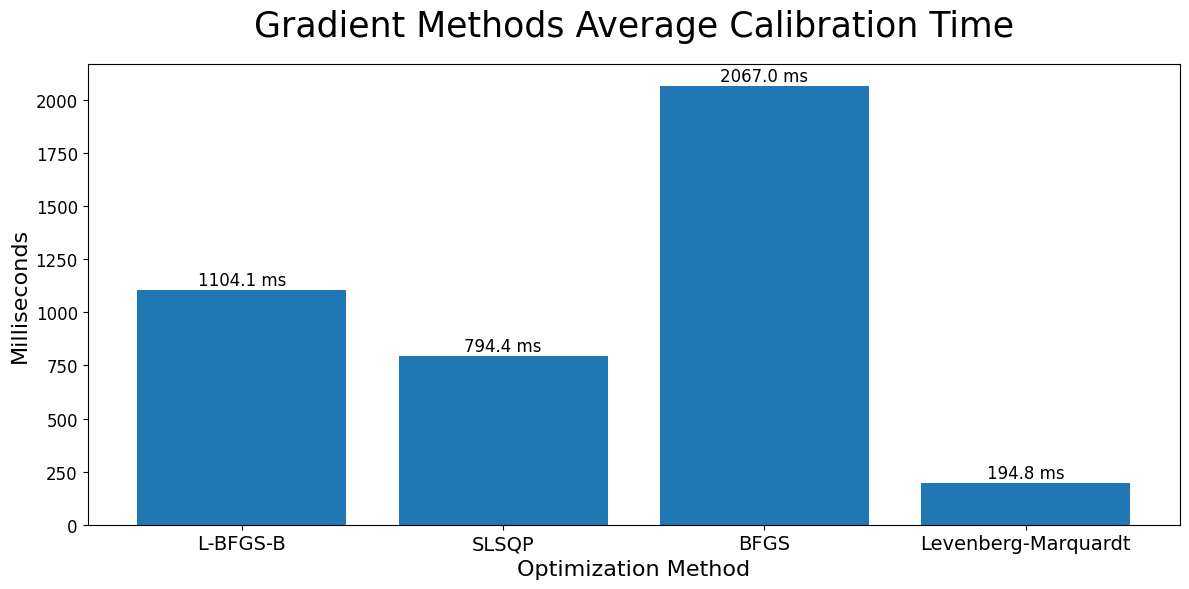

In [34]:
# =====================================================================================
# RESULTS ANALYSIS AND VISUALIZATION
# =====================================================================================

# Calculate average times in milliseconds
avg_times_ms = np.mean(times, axis=0) * 1000

# Plot settings
plt.figure(1, figsize=(12, 6))
bars = plt.bar(methods, avg_times_ms)

# Add exact numerical values above each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 5,
             f'{height:.1f} ms',
             ha='center', va='bottom', fontsize=12)

# Formatting
plt.title("Gradient Methods Average Calibration Time", fontsize=25, pad=20)
plt.ylabel("Milliseconds", fontsize=16)
plt.xlabel("Optimization Method", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=12)

# Adjust layout to prevent text clipping
plt.tight_layout()
plt.show()

Calibrated parameters shape: (1800, 5)
Test parameters shape: (1800, 5)


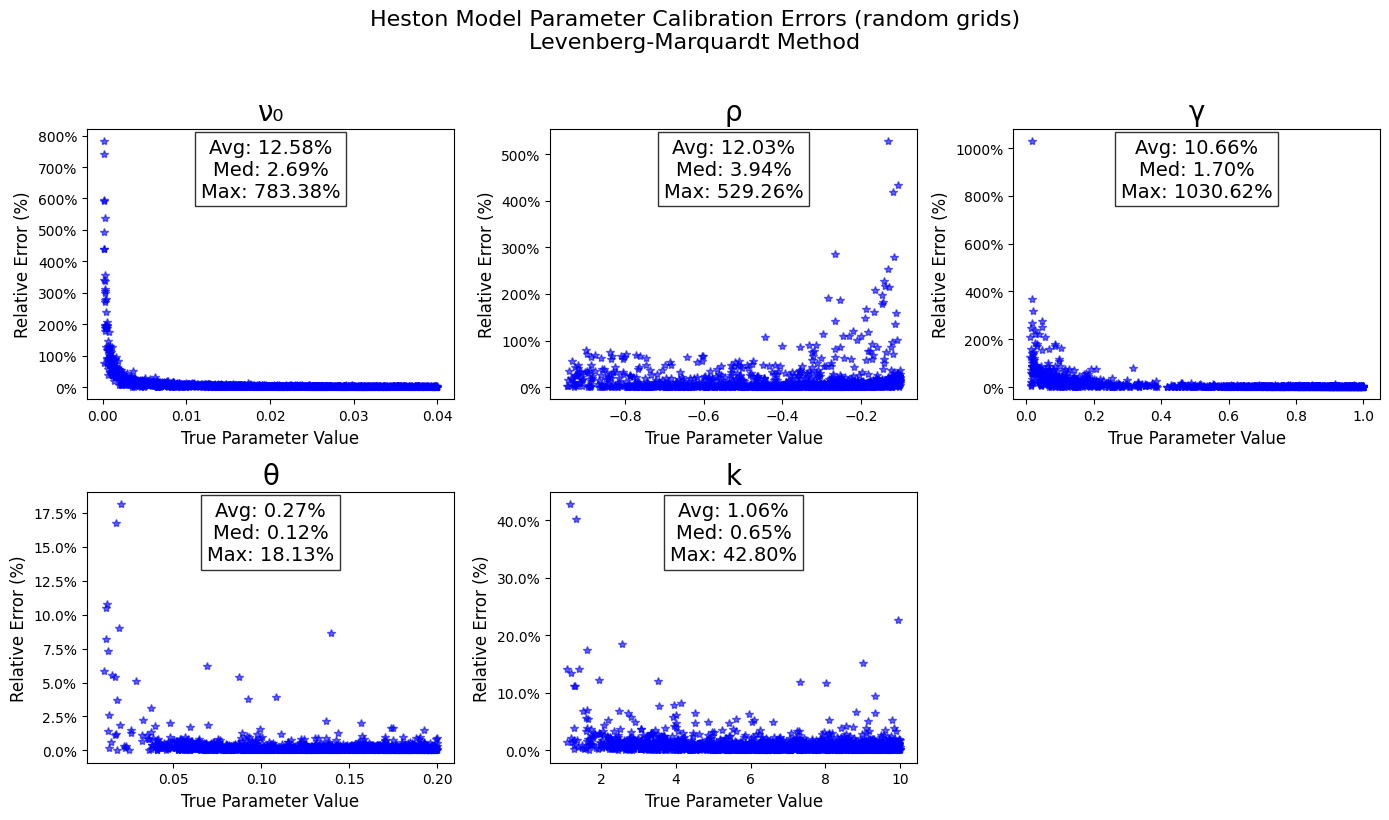


Summary Statistics of Relative Errors (%):
ν₀: Avg=12.58%, Med=2.69%, Max=783.38%
ρ: Avg=12.03%, Med=3.94%, Max=529.26%
γ: Avg=10.66%, Med=1.70%, Max=1030.62%
θ: Avg=0.27%, Med=0.12%, Max=18.13%
k: Avg=1.06%, Med=0.65%, Max=42.80%


In [35]:
# Extract Levenberg-Marquardt parameters (usually the best performing)
LMParameters = solutions[:, 3, :]

# Extract unique Heston parameters from X_test (remove duplicates and strike/maturity columns)
# Since parameters are repeated 143 times for each surface, we take every 143th row
X_test_compare = X_test[::143, :5]  # Take every 143th row and first 5 columns

# Verify shapes
print(f"Calibrated parameters shape: {LMParameters.shape}")  # Should be (1800, 5)
print(f"Test parameters shape: {X_test_compare.shape}")      # Should be (1800, 5)

# Verify dimensions
assert len(LMParameters) == len(X_test_compare), "Mismatch between calibrated parameters and test set"

# Plot relative errors for each parameter
titles = ["ν₀", "ρ", "γ", "θ", "k"]
relative_errors = np.zeros((len(LMParameters), 5))  # Store all relative errors

fig = plt.figure(figsize=(14, 8))
for param_idx in range(5):
    ax = plt.subplot(2, 3, param_idx+1)
    
    # Get true and calibrated parameters
    true_params = X_test_compare[:len(LMParameters), param_idx]
    calibrated_params = LMParameters[:, param_idx]
    
    # Calculate relative errors 
    with np.errstate(divide='ignore', invalid='ignore'):
        rel_errors = np.abs(calibrated_params - true_params) / np.abs(true_params)
    
    relative_errors[:, param_idx] = rel_errors
    
    # Plot
    plt.plot(true_params, 100 * rel_errors, 'b*', alpha=0.6)
    plt.title(titles[param_idx], fontsize=20)
    plt.xlabel('True Parameter Value', fontsize=12)
    plt.ylabel('Relative Error (%)', fontsize=12)
    plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
    
    # Add statistics
    stats_text = 'Avg: %1.2f%%\nMed: %1.2f%%\nMax: %1.2f%%' % (
        np.mean(100 * rel_errors),
        np.median(100 * rel_errors),
        np.max(100 * rel_errors))
    
    plt.text(0.5, 0.85, stats_text,
             horizontalalignment='center',
             verticalalignment='center',
             transform=ax.transAxes,
             fontsize=14,
             bbox=dict(facecolor='white', alpha=0.8))

plt.suptitle('Heston Model Parameter Calibration Errors (random grids)\nLevenberg-Marquardt Method', 
             fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

# Additional analysis
print("\nSummary Statistics of Relative Errors (%):")
for i, title in enumerate(titles):
    print(f"{title}: Avg={np.mean(100*relative_errors[:,i]):.2f}%, "
          f"Med={np.median(100*relative_errors[:,i]):.2f}%, "
          f"Max={np.max(100*relative_errors[:,i]):.2f}%")

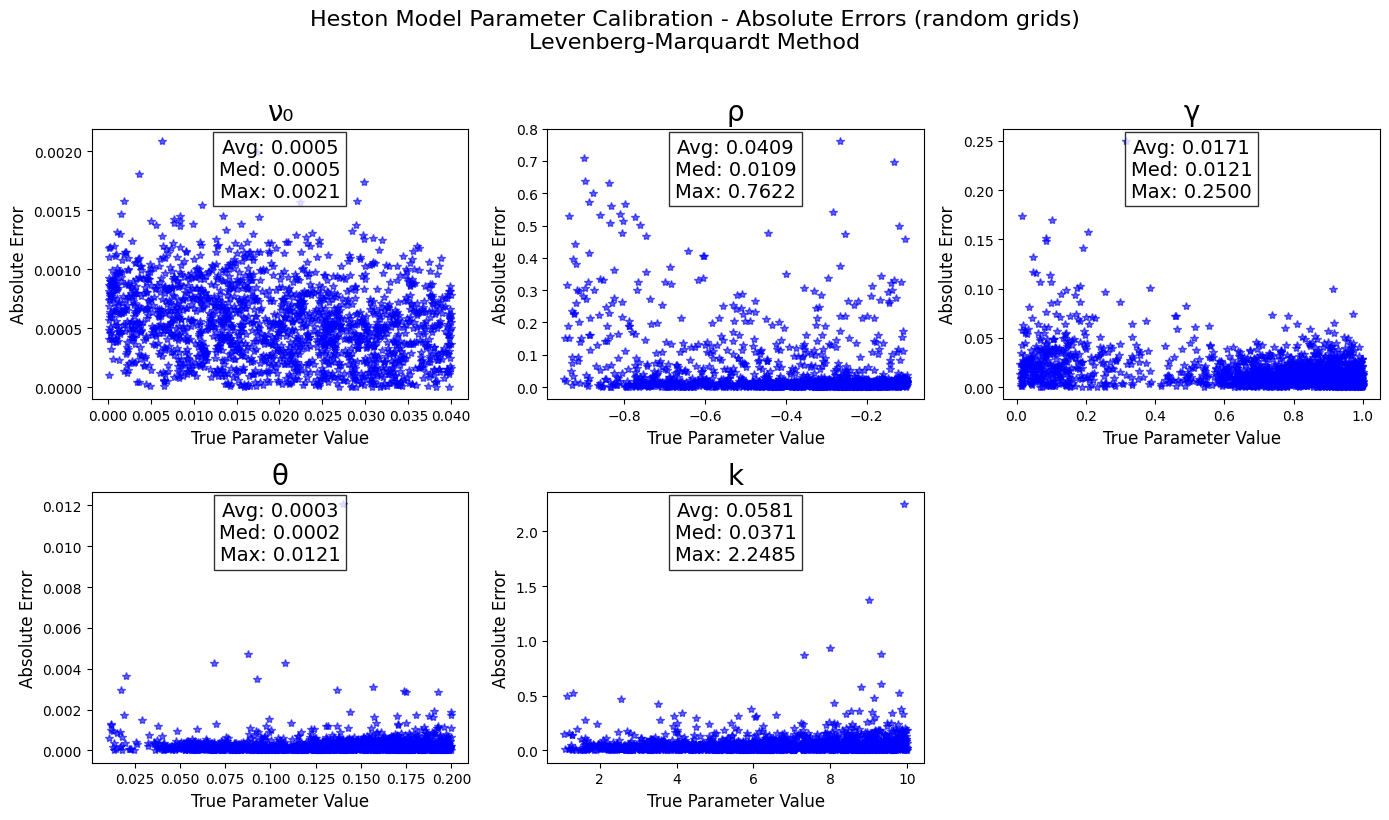


Summary Statistics of Absolute Errors:
ν₀: Avg=0.000549, Med=0.000527, Max=0.002090
ρ: Avg=0.040947, Med=0.010863, Max=0.762169
γ: Avg=0.017051, Med=0.012074, Max=0.250043
θ: Avg=0.000261, Med=0.000168, Max=0.012059
k: Avg=0.058086, Med=0.037070, Max=2.248463


In [36]:
# Correct parameter names and absolute error analysis
titles = ["ν₀", "ρ", "γ", "θ", "k"]
absolute_errors = np.zeros((len(LMParameters), 5))  # Store all absolute errors

fig = plt.figure(figsize=(14, 8))
for param_idx in range(5):
    ax = plt.subplot(2, 3, param_idx+1)
    
    # Get true and calibrated parameters
    true_params = X_test_compare[:len(LMParameters), param_idx]
    calibrated_params = LMParameters[:, param_idx]
    
    # Calculate absolute errors
    abs_errors = np.abs(calibrated_params - true_params)
    absolute_errors[:, param_idx] = abs_errors
    
    # Plot
    plt.plot(true_params, abs_errors, 'b*', alpha=0.6)
    plt.title(titles[param_idx], fontsize=20)
    plt.xlabel('True Parameter Value', fontsize=12)
    plt.ylabel('Absolute Error', fontsize=12)
    
    # Add statistics
    stats_text = 'Avg: %1.4f\nMed: %1.4f\nMax: %1.4f' % (
        np.mean(abs_errors),
        np.median(abs_errors),
        np.max(abs_errors))
    
    plt.text(0.5, 0.85, stats_text,
             horizontalalignment='center',
             verticalalignment='center',
             transform=ax.transAxes,
             fontsize=14,
             bbox=dict(facecolor='white', alpha=0.8))

plt.suptitle('Heston Model Parameter Calibration - Absolute Errors (random grids)\nLevenberg-Marquardt Method', 
             fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

# Additional analysis
print("\nSummary Statistics of Absolute Errors:")
for i, title in enumerate(titles):
    print(f"{title}: Avg={np.mean(absolute_errors[:,i]):.6f}, "
          f"Med={np.median(absolute_errors[:,i]):.6f}, "
          f"Max={np.max(absolute_errors[:,i]):.6f}")

# Gradient-free optimization
And here we will exploit 3 different gradient free optimization methods: **COBYLA**, **Differential Evolution** and **Nelder-Mayer**.
We will use this configuration of parameters for these algorithms and compare both accuracy and calibration time.

In [38]:
# =====================================================================================
# GRADIENT-FREE CALIBRATION WITH DIFFERENT ALGORITHMS
# =====================================================================================

# Define parameter bounds in scaled space [-1, 1] for all parameters
bounds_scaled = [(-1, 1) for _ in range(5)]

# Initialize arrays for results
n_surfaces = 120
n_methods = 3
n_params = 5

solutions_gf = np.zeros((n_surfaces, n_methods, n_params))  # [surface, method, param]
times_gf = np.zeros((n_surfaces, n_methods))

methods = ["COBYLA", "Differential Evolution", "Nelder-Mead"]
init_guess = np.zeros(5)  # Initial guess in [-1,1] scaled space

print("Starting Gradient-Free Calibration...")
print(f"Total surfaces to calibrate: {n_surfaces}")

# Main calibration loop
for surface_idx in range(n_surfaces):
    print(f"Calibrating surface {surface_idx+1}/{n_surfaces}", end="\r")
    strikes, maturities, market_ivs = calibration_data[surface_idx]
    
    # Define cost function for this surface, same as before without the gradient (note: it takes directly the current market data being inside the loop, no need to pass them)
    def fun(x):
        loss, _ = surface_cost_function(x, strikes, maturities, market_ivs)
        return loss
    
    # COBYLA (Constrained Optimization BY Linear Approximation)
    start = time.perf_counter()
    result = scipy.optimize.minimize(
        fun,
        x0=init_guess,
        method='COBYLA',
        bounds=bounds_scaled,
        options={
            "maxiter": 5000,
            "disp": False,
            "catol": 1e-8,
            "tol": 1e-10
        }
    )
    solutions_gf[surface_idx, 0, :] = unscale_heston_params(result.x)
    times_gf[surface_idx, 0] = time.perf_counter() - start
    
    # Differential Evolution
    start = time.perf_counter()
    result = scipy.optimize.differential_evolution(
        fun,
        bounds=bounds_scaled,
        popsize=50,
        strategy='best1bin',
        mutation=0.65,
        recombination=0.7,
        tol=0.01,
        maxiter=1000,
        disp=False,
        seed=42
    )
    solutions_gf[surface_idx, 1, :] = unscale_heston_params(result.x)
    times_gf[surface_idx, 1] = time.perf_counter() - start
    
    # Nelder-Mead (Simplex method)
    start = time.perf_counter()
    result = scipy.optimize.minimize(
        fun,
        x0=init_guess,
        method='Nelder-Mead',
        options={
            "maxiter": 5000,
            "maxfev": 10000,
            "disp": False,
            "xatol": 1e-8,
            "fatol": 1e-10,
            "adaptive": True
        }
    )
    solutions_gf[surface_idx, 2, :] = unscale_heston_params(result.x)
    times_gf[surface_idx, 2] = time.perf_counter() - start

print("\nGradient-Free Calibration completed!")

Starting Gradient-Free Calibration...
Total surfaces to calibrate: 120
Calibrating surface 120/120
Gradient-Free Calibration completed!


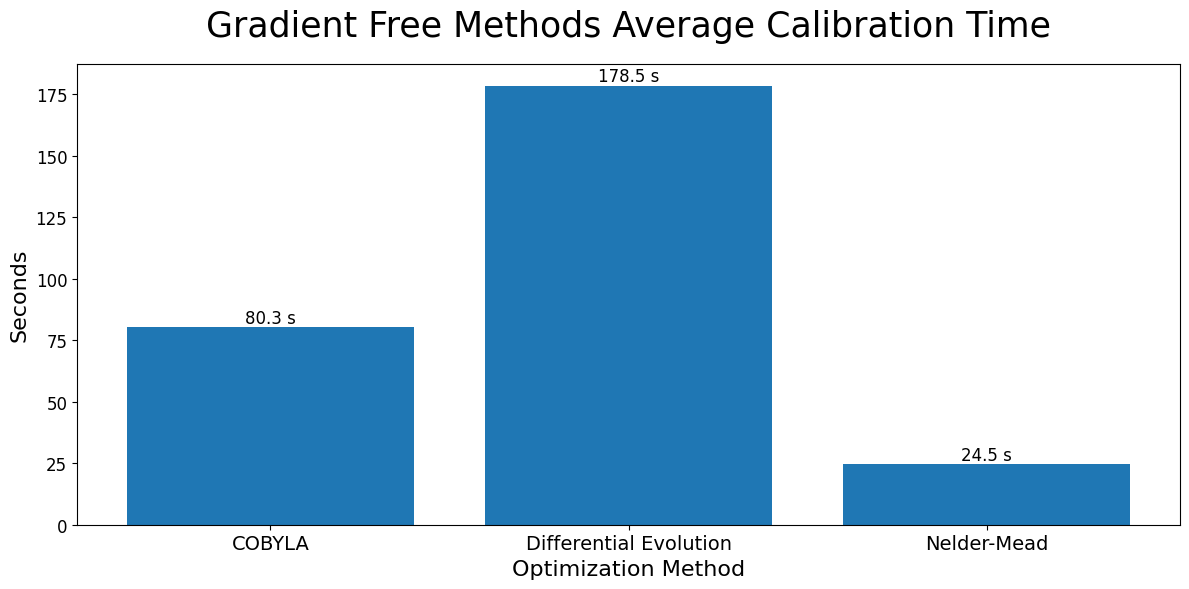

In [39]:
# =====================================================================================
# RESULTS ANALYSIS AND VISUALIZATION
# =====================================================================================

# Calculate average times in milliseconds
avg_times_ms = np.mean(times_gf, axis=0)

# Plot settings
plt.figure(1, figsize=(12, 6))
bars = plt.bar(methods, avg_times_ms)

# Add exact numerical values above each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.25,
             f'{height:.1f} s',
             ha='center', va='bottom', fontsize=12)

# Formatting
plt.title("Gradient Free Methods Average Calibration Time", fontsize=25, pad=20)
plt.ylabel("Seconds", fontsize=16)
plt.xlabel("Optimization Method", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=12)

# Adjust layout to prevent text clipping
plt.tight_layout()
plt.show()

Calibrated parameters shape: (120, 5)
Test parameters shape: (120, 5)


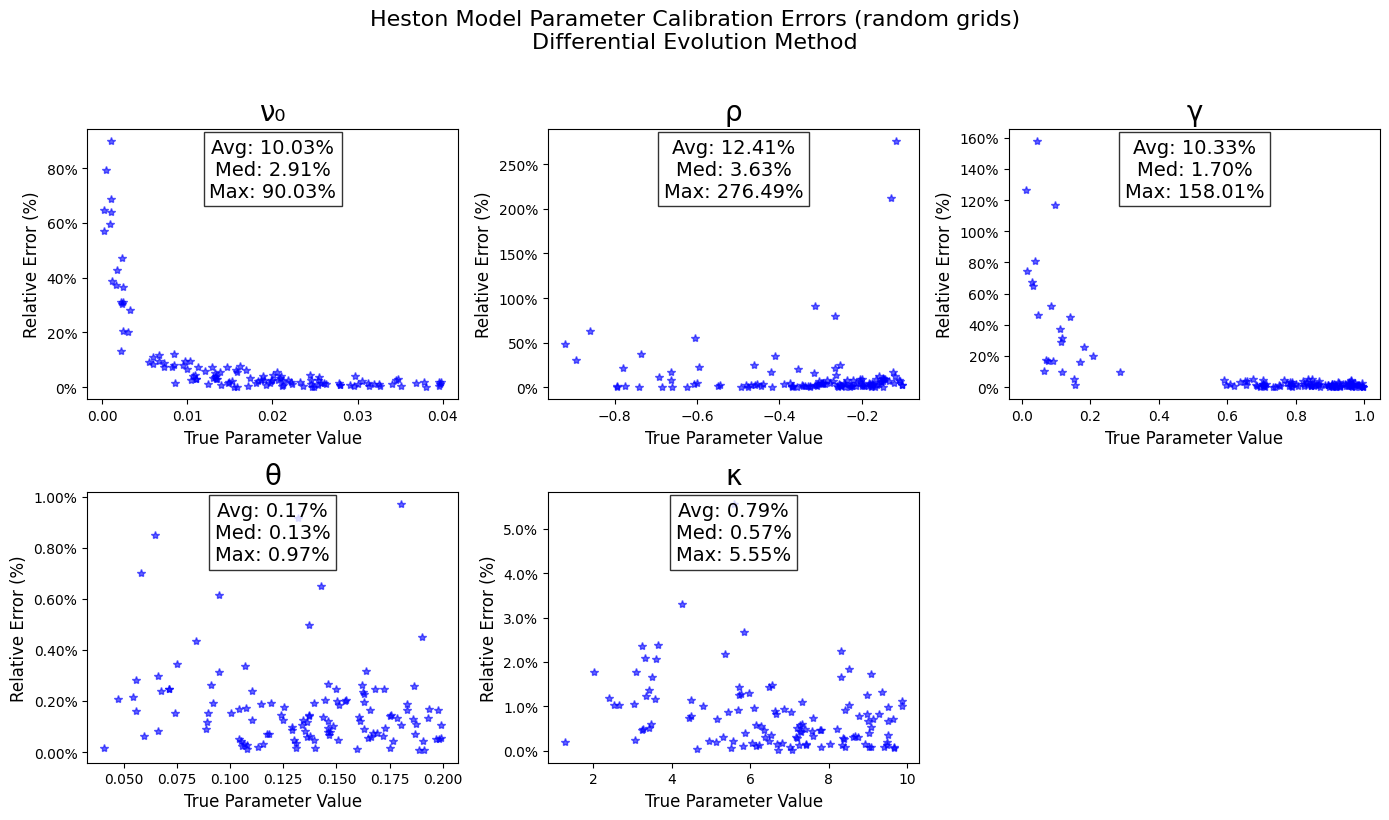


Summary Statistics of Relative Errors (%):
ν₀: Avg=10.03%, Med=2.91%, Max=90.03%
ρ: Avg=12.41%, Med=3.63%, Max=276.49%
γ: Avg=10.33%, Med=1.70%, Max=158.01%
θ: Avg=0.17%, Med=0.13%, Max=0.97%
κ: Avg=0.79%, Med=0.57%, Max=5.55%


In [40]:
# Extract Differential Evolution parameters (usually the best performing)
DEParameters = solutions_gf[:, 1, :]

# Extract unique Heston parameters from X_test (remove duplicates and strike/maturity columns)
# Since parameters are repeated 143 times for each surface, we take every 143th row
X_test_compare = X_test[::143, :5]  # Take every 143th row and first 5 columns
X_test_compare = X_test_compare[:n_surfaces,:]

# Verify shapes
print(f"Calibrated parameters shape: {DEParameters.shape}")  # Should be (360, 5)
print(f"Test parameters shape: {X_test_compare.shape}")      # Should be (360, 5)

# Verify dimensions
assert len(DEParameters) == len(X_test_compare), "Mismatch between calibrated parameters and test set"

# Plot relative errors for each parameter
titles = ["ν₀", "ρ", "γ", "θ", "κ"]
relative_errors = np.zeros((len(DEParameters), 5))  # Store all relative errors

fig = plt.figure(figsize=(14, 8))
for param_idx in range(5):
    ax = plt.subplot(2, 3, param_idx+1)
    
    # Get true and calibrated parameters
    true_params = X_test_compare[:, param_idx]
    calibrated_params = DEParameters[:, param_idx]
    
    # Calculate relative errors
    with np.errstate(divide='ignore', invalid='ignore'):
        rel_errors = np.abs(calibrated_params - true_params) / np.abs(true_params)
    
    relative_errors[:, param_idx] = rel_errors
    
    # Plot
    plt.plot(true_params, 100 * rel_errors, 'b*', alpha=0.6)
    plt.title(titles[param_idx], fontsize=20)
    plt.xlabel('True Parameter Value', fontsize=12)
    plt.ylabel('Relative Error (%)', fontsize=12)
    plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
    
    # Add statistics
    stats_text = 'Avg: %1.2f%%\nMed: %1.2f%%\nMax: %1.2f%%' % (
        np.mean(100 * rel_errors),
        np.median(100 * rel_errors),
        np.max(100 * rel_errors))
    
    plt.text(0.5, 0.85, stats_text,
             horizontalalignment='center',
             verticalalignment='center',
             transform=ax.transAxes,
             fontsize=14,
             bbox=dict(facecolor='white', alpha=0.8))

plt.suptitle('Heston Model Parameter Calibration Errors (random grids)\nDifferential Evolution Method', 
             fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

# Additional analysis
print("\nSummary Statistics of Relative Errors (%):")
for i, title in enumerate(titles):
    print(f"{title}: Avg={np.mean(100*relative_errors[:,i]):.2f}%, "
          f"Med={np.median(100*relative_errors[:,i]):.2f}%, "
          f"Max={np.max(100*relative_errors[:,i]):.2f}%")

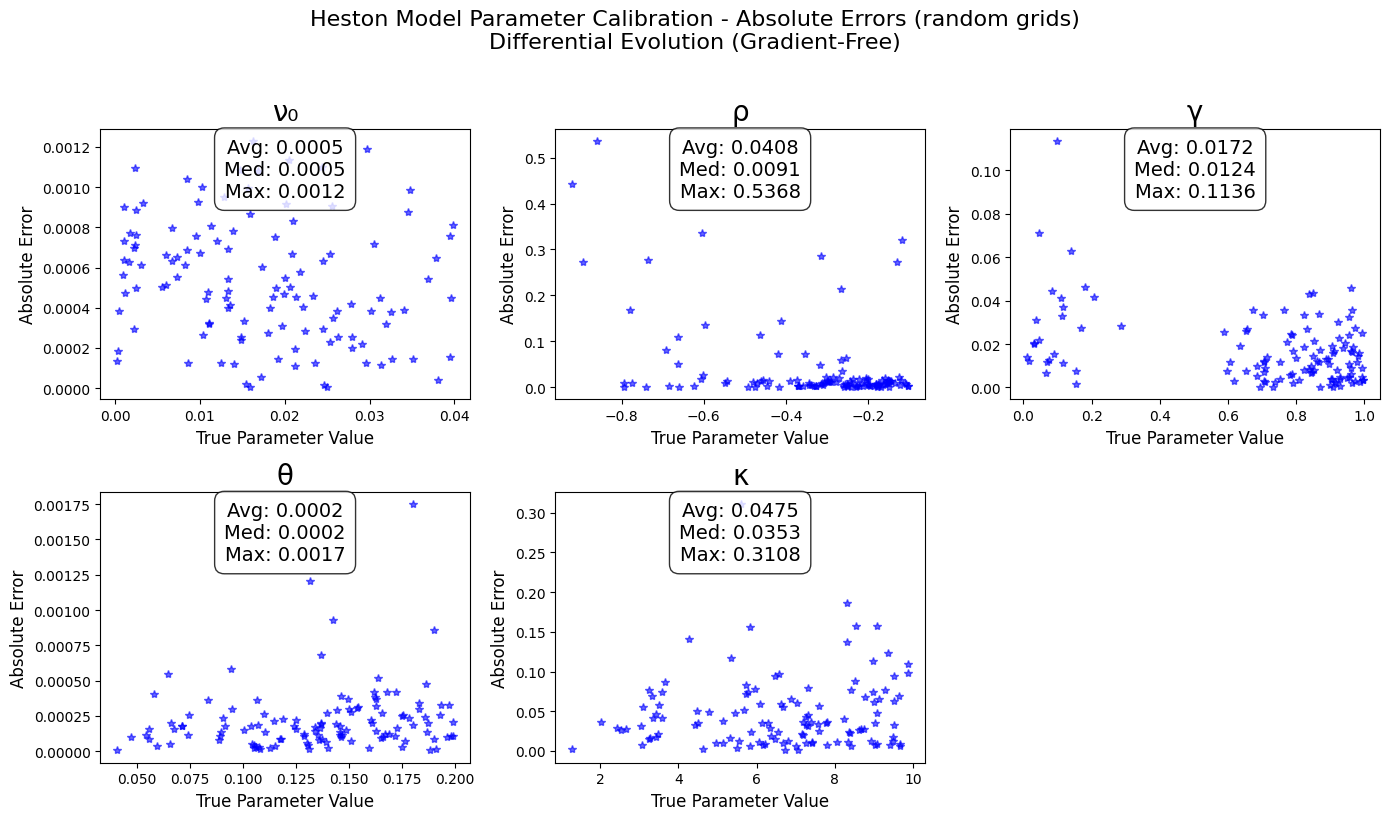


Summary Statistics of Absolute Errors:
ν₀: Avg=0.000526, Med=0.000499, Max=0.001231
ρ: Avg=0.040787, Med=0.009129, Max=0.536827
γ: Avg=0.017184, Med=0.012449, Max=0.113649
θ: Avg=0.000222, Med=0.000167, Max=0.001749
κ: Avg=0.047471, Med=0.035319, Max=0.310766


In [41]:
# Plot absolute errors for each parameter
titles = ["ν₀", "ρ", "γ", "θ", "κ"]
absolute_errors = np.zeros((len(DEParameters), 5))  # Store all absolute errors

fig = plt.figure(figsize=(14, 8))
for param_idx in range(5):
    ax = plt.subplot(2, 3, param_idx+1)
    
    # Get true and calibrated parameters
    true_params = X_test_compare[:, param_idx]
    calibrated_params = DEParameters[:, param_idx]
    
    # Calculate absolute errors
    abs_errors = np.abs(calibrated_params - true_params)
    absolute_errors[:, param_idx] = abs_errors
    
    # Plot with consistent style
    plt.plot(true_params, abs_errors, 'b*', alpha=0.6)
    plt.title(titles[param_idx], fontsize=20)
    plt.xlabel('True Parameter Value', fontsize=12)
    plt.ylabel('Absolute Error', fontsize=12)
    
    # Add statistics with consistent formatting
    stats_text = 'Avg: %1.4f\nMed: %1.4f\nMax: %1.4f' % (
        np.mean(abs_errors),
        np.median(abs_errors),
        np.max(abs_errors))
    
    plt.text(0.5, 0.85, stats_text,
             horizontalalignment='center',
             verticalalignment='center',
             transform=ax.transAxes,
             fontsize=14,
             bbox=dict(facecolor='white', alpha=0.8,
                      boxstyle='round,pad=0.5'))

plt.suptitle('Heston Model Parameter Calibration - Absolute Errors (random grids)\nDifferential Evolution (Gradient-Free)', 
             fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

# Additional analysis with consistent output format
print("\nSummary Statistics of Absolute Errors:")
for i, title in enumerate(titles):
    print(f"{title}: Avg={np.mean(absolute_errors[:,i]):.6f}, "
          f"Med={np.median(absolute_errors[:,i]):.6f}, "
          f"Max={np.max(absolute_errors[:,i]):.6f}")